Introducción y lectura de bases de datos.

En este primer informe nos proponemos hacer una primera aproximación a los resultados electorales obtenidos por el partido 3 en la Ciudad Autónoma de Buenos Aires y analizarlos en relación con ciertas variables sociodemográficas de la población, para así poder llegar a trazar un primer perfil del votante y ejecutar acciones de campaña en ese sentido. Con este objetivo, nos dirigimos a hacer lectura de la información obtenida. 

In [2]:
from itertools import count
from statistics import geometric_mean
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt


Como primer paso, abrimos las bases de datos "resultados_paso" y "circuitos_electorales"(base descargada del GCBA que usaremos para vincular circuitos electorales con comunas).

In [5]:
resultados_paso = pd.read_csv(
    "paso_x_partido.csv" "",
    delimiter=",",  # delimitador ',',';','|','\t'
    header=0,  # número de fila como nombre de columna
    names=None,  # nombre de las columnas (ojo con header)
    index_col=0,  # que col es el índice
    usecols=None,  # que col usar. Ej: [0, 1, 2], ['foo', 'bar', 'baz']
    dtype=None,  # Tipo de col {'a': np.int32, 'b': str}
    skiprows=None,  # saltear filas al inicio
    skipfooter=0,  # saltear filas al final
    nrows=None,  # n de filas a leer
    decimal=".",  # separador de decimal. Ej: ',' para EU dat
    quotechar='"',  # char para reconocer str
    encoding=None,
)

resultados_paso  # archivos con tilde y ñ por lo general utilizan "utf-8" etc
#%%
comunas = pd.read_csv(
    "circuitos-electorales.csv",
    delimiter=",",  # delimitador ',',';','|','\t'
    header=0,  # número de fila como nombre de columna
    names=None,  # nombre de las columnas (ojo con header)
    index_col=0,  # que col es el índice
    usecols=None,  # que col usar. Ej: [0, 1, 2], ['foo', 'bar', 'baz']
    dtype=None,  # Tipo de col {'a': np.int32, 'b': str}
    skiprows=None,  # saltear filas al inicio
    skipfooter=0,  # saltear filas al final
    nrows=None,  # n de filas a leer
    decimal=".",  # separador de decimal. Ej: ',' para EU dat
    quotechar='"',  # char para reconocer str
    encoding=None,
)

Vinculamos circuitos electorales con comunas.

In [4]:
circuito_comuna = comunas[["COMUNA", "CIRCUITO_N", "BARRIO"]].rename(
    columns={"CIRCUITO_N": "circuito"}
)
circuito_comuna = circuito_comuna.sort_values(by=["circuito"])
circuito_comuna = circuito_comuna.reset_index(drop=True)

tabla_final = pd.merge(
    resultados_paso, circuito_comuna, on="circuito", how="outer", indicator=True
)
tabla_final

circuito  urna  pp1  pp2  pp3  pp4  nv  COMUNA     BARRIO _merge
0            1     0   64   74   49   50  63       1  SAN TELMO   both
1            1     1   79   81   44   36  60       1  SAN TELMO   both
2            1     2   72   74   55   34  65       1  SAN TELMO   both
3            1     3   82   80   37   38  63       1  SAN TELMO   both
4            1     4   64   87   57   28  64       1  SAN TELMO   both
...        ...   ...  ...  ...  ...  ...  ..     ...        ...    ...
7634       167    32   76   46   56   66  56      15  AGRONOMIA   both
7635       167    33   62   59   51   57  71      15  AGRONOMIA   both
7636       167    34   63   52   51   69  65      15  AGRONOMIA   both
7637       167    35   68   66   51   64  51      15  AGRONOMIA   both
7638       167    36   70   42   39   57  41      15  AGRONOMIA   both

[7639 rows x 10 columns]

Pasamos a analizar la distribución de votos que tuvo cada candidato. Esto es, sobre el 100% que obtuvo, por ejemplo, el candidato 3, se analiza la distribución de ese total que tuvo por comunas. En este caso, el porcentaje de votos es analizado para cada candidato de forma aislada.

In [6]:
distrib_candidatos = (
    tabla_final[["COMUNA", "pp1", "pp2", "pp3", "pp4", "nv", "BARRIO",]]
    .groupby(["COMUNA"])
    .sum()
    .transform(lambda x: (x + 0.0) / x.sum() * 100)
)
distrib_candidatos

C:\Users\ivanl\AppData\Local\Temp\ipykernel_8644\2591842797.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tabla_final[["COMUNA", "pp1", "pp2", "pp3", "pp4", "nv", "BARRIO",]]


pp1       pp2        pp3       pp4        nv
COMUNA                                                   
1       7.232794  9.450333   5.152216  4.998396  6.698759
2       4.439748  4.805121   7.125770  6.884241  5.815161
3       7.573100  7.902294   5.214219  5.623694  6.537122
4       8.411547  9.968829   4.995669  5.114962  7.105827
5       6.772836  6.259406   6.069294  6.360912  6.419809
6       5.903311  4.896027   7.384997  7.114055  6.272286
7       7.524485  8.139089   7.119394  6.815452  7.480038
8       6.617667  9.496991   3.263092  3.665963  5.781864
9       6.131736  5.339826   5.227412  5.180434  5.415370
10      5.920626  4.673470   6.245190  6.167815  5.809428
11      6.458724  4.830750   7.697432  7.417082  6.551456
12      6.769284  5.496667   7.867612  8.208934  7.085539
13      6.975288  5.926009  10.521004  9.929773  8.383923
14      6.683819  6.824340   9.782900  9.799051  8.202881
15      6.585034  5.990848   6.333798  6.719236  6.440537

A continuación, se expresa la cantidad de votos que obtuvo cada candidato, agrupado por comuna y por circuito electoral.

In [7]:
total_votos_x_comunas = (
    tabla_final[["COMUNA","circuito", "pp1", "pp2", "pp3", "pp4", "nv", "BARRIO"]]
    .groupby(["COMUNA","circuito"])
    .sum()
)
total_votos_x_comunas

C:\Users\ivanl\AppData\Local\Temp\ipykernel_8644\2914924009.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tabla_final[["COMUNA","circuito", "pp1", "pp2", "pp3", "pp4", "nv", "BARRIO"]]


pp1   pp2   pp3   pp4    nv
COMUNA circuito                              
1      1         1955  2113  1237  1182  1655
       2         2005  2122  1220  1390  1618
       3          600   812   286   383   509
       4          336   371   140   196   240
       5         4053  4071  3029  2929  3443
...               ...   ...   ...   ...   ...
15     163       2290  2276  2040  2174  2174
       164       2095  1900  2039  2106  2119
       165       3618  3588  3157  3399  3501
       166       2970  2569  2773  2878  2798
       167       2358  2033  2091  2317  2250

[167 rows x 5 columns]

Entonces, se agrega una columna para expresar la cantidad de votantes, también agrupado por comuna y por circuito electoral.

In [8]:
total_votos_x_comunas = total_votos_x_comunas.assign(
    total=lambda x: (x["pp1"] + x["pp2"] + x["pp3"] + x["pp4"] + x["nv"])
)
total_votos_x_comunas

pp1   pp2   pp3   pp4    nv  total
COMUNA circuito                                     
1      1         1955  2113  1237  1182  1655   8142
       2         2005  2122  1220  1390  1618   8355
       3          600   812   286   383   509   2590
       4          336   371   140   196   240   1283
       5         4053  4071  3029  2929  3443  17525
...               ...   ...   ...   ...   ...    ...
15     163       2290  2276  2040  2174  2174  10954
       164       2095  1900  2039  2106  2119  10259
       165       3618  3588  3157  3399  3501  17263
       166       2970  2569  2773  2878  2798  13988
       167       2358  2033  2091  2317  2250  11049

[167 rows x 6 columns]

Ahora calculamos el porcentaje de votos que obtuvo cada candidato, agrupando por comuna y por circuito electoral.

In [9]:
porcentaje_votos_x_comunas = total_votos_x_comunas.transform(
    (lambda x: (x + 0.0) / x["total"] * 100), axis=1
)
porcentaje_votos_x_comunas

pp1        pp2        pp3        pp4         nv  total
COMUNA circuito                                                              
1      1         24.011299  25.951855  15.192827  14.517318  20.326701  100.0
       2         23.997606  25.397965  14.602035  16.636744  19.365649  100.0
       3         23.166023  31.351351  11.042471  14.787645  19.652510  100.0
       4         26.188620  28.916602  10.911925  15.276695  18.706157  100.0
       5         23.126961  23.229672  17.283880  16.713267  19.646220  100.0
...                    ...        ...        ...        ...        ...    ...
15     163       20.905605  20.777798  18.623334  19.846631  19.846631  100.0
       164       20.421094  18.520324  19.875232  20.528317  20.655035  100.0
       165       20.958119  20.784336  18.287667  19.689509  20.280368  100.0
       166       21.232485  18.365742  19.824135  20.574778  20.002860  100.0
       167       21.341298  18.399855  18.924790  20.970224  20.363834  100.0

[167 rows x 6 columns]

In [10]:
porcentaje_votos_x_comunas.reset_index(inplace=True)

In [11]:
porcentaje_votos_x_comunas

COMUNA  circuito        pp1        pp2        pp3        pp4         nv  \
0         1         1  24.011299  25.951855  15.192827  14.517318  20.326701   
1         1         2  23.997606  25.397965  14.602035  16.636744  19.365649   
2         1         3  23.166023  31.351351  11.042471  14.787645  19.652510   
3         1         4  26.188620  28.916602  10.911925  15.276695  18.706157   
4         1         5  23.126961  23.229672  17.283880  16.713267  19.646220   
..      ...       ...        ...        ...        ...        ...        ...   
162      15       163  20.905605  20.777798  18.623334  19.846631  19.846631   
163      15       164  20.421094  18.520324  19.875232  20.528317  20.655035   
164      15       165  20.958119  20.784336  18.287667  19.689509  20.280368   
165      15       166  21.232485  18.365742  19.824135  20.574778  20.002860   
166      15       167  21.341298  18.399855  18.924790  20.970224  20.363834   

     total  
0    100.0  
1    100.0  
2    100.0  
3    100.0  
4    100.0  
..     ...  
162  100.0  
163  100.0  
164  100.0  
165  100.0  
166  100.0  

[167 rows x 8 columns]

En vistas de hacer más fácil el análisis, ordenamos los circuitos electorales en función del desempeño de nuestro candidato.

In [12]:
porcentaje_orden = porcentaje_votos_x_comunas.sort_values(["pp3"], ascending=False)
porcentaje_orden

COMUNA  circuito        pp1        pp2        pp3        pp4         nv  \
20        2        21  14.911404   9.859155  32.975920  21.899137  20.354384   
143      13       144  13.819275   9.752255  32.120865  23.857941  20.449663   
19        2        20  14.582606  14.093608  30.387705  20.817324  20.118757   
137      13       138  13.913556  10.998035  30.133595  24.632613  20.322200   
154      14       155  13.342616  12.137507  29.791627  25.000000  19.728250   
..      ...       ...        ...        ...        ...        ...        ...   
75        7        76  19.127813  41.719370   8.817473   9.957347  20.377997   
43        4        44  21.073095  48.367030   4.406428   5.728357  20.425091   
44        4        45  20.645574  50.079898   3.739214   5.512943  20.022371   
5         1         6  17.301650  54.588898   3.698612   4.660906  19.749935   
42        4        43  20.918087  53.555067   2.253986   3.481767  19.791094   

     total  
20   100.0  
143  100.0  
19   100.0  
137  100.0  
154  100.0  
..     ...  
75   100.0  
43   100.0  
44   100.0  
5    100.0  
42   100.0  

[167 rows x 8 columns]

Abrimos las bases de datos del censo.

In [14]:
hogar = pd.read_csv(r"C:\Users\ivanl\OneDrive\Escritorio\VSCode\censo\hogar.csv", sep=",")

#
vivienda = pd.read_csv(r"C:\Users\ivanl\OneDrive\Escritorio\VSCode\censo\vivienda.csv", sep=",")

#
persona = pd.read_csv(r"C:\Users\ivanl\OneDrive\Escritorio\VSCode\censo\persona.csv", sep=",")

#
prov = pd.read_csv(r"C:\Users\ivanl\OneDrive\Escritorio\VSCode\censo\prov.csv", sep=",")

# 
radio = pd.read_csv(r"C:\Users\ivanl\OneDrive\Escritorio\VSCode\censo\radio.csv")

# 
frac = pd.read_csv(r"C:\Users\ivanl\OneDrive\Escritorio\VSCode\censo\frac.csv")

Utilizamos la siguiente linea de codigo para vincular las comunas, con las personas, viviendas y hogares.

In [15]:
dpto = pd.read_csv(r"C:\Users\ivanl\OneDrive\Escritorio\MET4OP-PP3\GRUPO_GANADOR\dpto.csv")
dpto = dpto[["DPTO_REF_ID", "NOMDPTO"]]
#dpto
# %%
dpto_frac = pd.merge(dpto, frac, on="DPTO_REF_ID", how="left")
dpto_frac.groupby = ["NOMDPTO"]
#dpto_frac
# %%
dpto_frac_radio = pd.merge(dpto_frac, radio, on="FRAC_REF_ID", how="right")
#dpto_frac_radio

# %%
dpto_frac_radio_vivienda = pd.merge(
    dpto_frac_radio, vivienda, on="RADIO_REF_ID", how="right", indicator=True
)
dpto_frac_radio_vivienda.rename(columns={"DPTO_REF_ID": "COMUNA"}, inplace=True)
#dpto_frac_radio_vivienda
#%%

# %%
#dpto_frac_radio_vivienda
# %%
hogarSUPREMO = pd.merge(
    dpto_frac_radio_vivienda, hogar, on="VIVIENDA_REF_ID", how="right"
)

En la siguiente variable, se almacena por comuna el cruce de todas las variables de hogares y viviendas.

In [16]:
hogarSUPREMO

COMUNA                                            NOMDPTO  \
0             1  Comuna 01                                     ...   
1             1  Comuna 01                                     ...   
2             1  Comuna 01                                     ...   
3             1  Comuna 01                                     ...   
4             1  Comuna 01                                     ...   
...         ...                                                ...   
1152594      15  Comuna 15                                     ...   
1152595      15  Comuna 15                                     ...   
1152596      15  Comuna 15                                     ...   
1152597      15  Comuna 15                                     ...   
1152598      15  Comuna 15                                     ...   

         FRAC_REF_ID  IDFRAC  RADIO_REF_ID  IDRADIO  VIVIENDA_REF_ID  TIPVV  \
0                  1       1             1        1                1      1   
1                  1       1             1        1                1      1   
2                  1       1             1        1                1      1   
3                  1       1             1        1                1      1   
4                  1       1             1        1                2      1   
...              ...     ...           ...      ...              ...    ...   
1152594          351      21          3553       13          1426434      1   
1152595          351      21          3553       13          1426435      1   
1152596          351      21          3553       13          1426436      1   
1152597          351      21          3553       13          1426437      2   
1152598          351      21          3553       13          1426438      2   

         V01  V02  ...  H15  H16  H19A  H19B  H19C  H19D  PROP  INDHAC  \
0          1    1  ...    2    2     1     2     1     2     5       1   
1          1    1  ...    1    2     1     1     1     1     1       1   
2          1    1  ...    3    5     1     1     1     1     1       1   
3          1    1  ...    3    5     1     1     1     1     5       6   
4          7    1  ...    5    5     1     1     2     1     6       1   
...      ...  ...  ...  ...  ...   ...   ...   ...   ...   ...     ...   
1152594    4    1  ...    2    3     1     1     1     1     1       1   
1152595    4    1  ...    1    2     1     2     2     1     1       1   
1152596    4    1  ...    2    3     1     1     1     1     1       3   
1152597    0    0  ...    0    0     0     0     0     0     0       7   
1152598    0    0  ...    0    0     0     0     0     0     0       7   

        TOTPERS  ALGUNBI  
0             1        0  
1             1        0  
2             2        0  
3             8        1  
4             2        1  
...         ...      ...  
1152594       1        0  
1152595       1        0  
1152596       3        0  
1152597       0        2  
1152598       0        2  

[1152599 rows x 41 columns]

En la siguiente variable, se almacena por comuna el cruce de todas las variables de hogares, viviendas y personas.

In [17]:
personaSUPREMO = pd.merge(hogarSUPREMO, persona, on="HOGAR_REF_ID", how="right")
personaSUPREMO

COMUNA                                            NOMDPTO  \
0             1  Comuna 01                                     ...   
1             1  Comuna 01                                     ...   
2             1  Comuna 01                                     ...   
3             1  Comuna 01                                     ...   
4             1  Comuna 01                                     ...   
...         ...                                                ...   
2890146      15  Comuna 15                                     ...   
2890147      15  Comuna 15                                     ...   
2890148      15  Comuna 15                                     ...   
2890149      15  Comuna 15                                     ...   
2890150      15  Comuna 15                                     ...   

         FRAC_REF_ID  IDFRAC  RADIO_REF_ID  IDRADIO  VIVIENDA_REF_ID  TIPVV  \
0                  1       1             1        1                1      1   
1                  1       1             1        1                1      1   
2                  1       1             1        1                1      1   
3                  1       1             1        1                1      1   
4                  1       1             1        1                1      1   
...              ...     ...           ...      ...              ...    ...   
2890146          351      21          3553       13          1426438      2   
2890147          351      21          3553       13          1426438      2   
2890148          351      21          3553       13          1426438      2   
2890149          351      21          3553       13          1426438      2   
2890150          351      21          3553       13          1426438      2   

         V01  V02  ...  P05  P06  P07  P12  EDADAGRU  EDADQUI  P08  P09 P10  \
0          1    1  ...    1    0    1    2         2       13    2    4   2   
1          1    1  ...    1    0    1    1         2       10    2    4   1   
2          1    1  ...    1    0    1    1         3       14    2    7   2   
3          1    1  ...    1    0    1    1         2       13    2    6   1   
4          1    1  ...    2  221    1    1         2        5    1    4   2   
...      ...  ...  ...  ...  ...  ...  ...       ...      ...  ...  ...  ..   
2890146    0    0  ...    1    0    1    0         3       20    2    2   1   
2890147    0    0  ...    1    0    1    0         3       19    2    6   1   
2890148    0    0  ...    1    0    1    0         3       17    2    2   1   
2890149    0    0  ...    1    0    1    0         3       18    2    2   1   
2890150    0    0  ...    1    0    1    0         3       19    2    2   1   

         CONDACT  
0              1  
1              1  
2              1  
3              3  
4              1  
...          ...  
2890146        0  
2890147        0  
2890148        0  
2890149        0  
2890150        0  

[2890151 rows x 55 columns]

A continuación, analizamos la cantidad de personas censadas que efectivamente son votantes.

In [20]:
votantes = personaSUPREMO[personaSUPREMO["P03"] >= 18]
votantes


COMUNA                                            NOMDPTO  \
0             1  Comuna 01                                     ...   
1             1  Comuna 01                                     ...   
2             1  Comuna 01                                     ...   
3             1  Comuna 01                                     ...   
4             1  Comuna 01                                     ...   
...         ...                                                ...   
2890146      15  Comuna 15                                     ...   
2890147      15  Comuna 15                                     ...   
2890148      15  Comuna 15                                     ...   
2890149      15  Comuna 15                                     ...   
2890150      15  Comuna 15                                     ...   

         FRAC_REF_ID  IDFRAC  RADIO_REF_ID  IDRADIO  VIVIENDA_REF_ID  TIPVV  \
0                  1       1             1        1                1      1   
1                  1       1             1        1                1      1   
2                  1       1             1        1                1      1   
3                  1       1             1        1                1      1   
4                  1       1             1        1                1      1   
...              ...     ...           ...      ...              ...    ...   
2890146          351      21          3553       13          1426438      2   
2890147          351      21          3553       13          1426438      2   
2890148          351      21          3553       13          1426438      2   
2890149          351      21          3553       13          1426438      2   
2890150          351      21          3553       13          1426438      2   

         V01  V02  ...  P05  P06  P07  P12  EDADAGRU  EDADQUI  P08  P09 P10  \
0          1    1  ...    1    0    1    2         2       13    2    4   2   
1          1    1  ...    1    0    1    1         2       10    2    4   1   
2          1    1  ...    1    0    1    1         3       14    2    7   2   
3          1    1  ...    1    0    1    1         2       13    2    6   1   
4          1    1  ...    2  221    1    1         2        5    1    4   2   
...      ...  ...  ...  ...  ...  ...  ...       ...      ...  ...  ...  ..   
2890146    0    0  ...    1    0    1    0         3       20    2    2   1   
2890147    0    0  ...    1    0    1    0         3       19    2    6   1   
2890148    0    0  ...    1    0    1    0         3       17    2    2   1   
2890149    0    0  ...    1    0    1    0         3       18    2    2   1   
2890150    0    0  ...    1    0    1    0         3       19    2    2   1   

         CONDACT  
0              1  
1              1  
2              1  
3              3  
4              1  
...          ...  
2890146        0  
2890147        0  
2890148        0  
2890149        0  
2890150        0  

[2325119 rows x 55 columns]

Análisis de los resultados electorales del partido 3.

A continuación, pasamos a hacer un análisis sobre la distribución de votos del partido 3 por circuito electoral. Para esto, vamos a generar un mapa que nos permita visualizar claramente esta distribución. Para esto, necesitamos de un geodataframe con los circuitos electorales de CABA.

In [21]:
caba_shp = gpd.read_file(
    "CABA.shp"
)
caba_shp["circuito"]=caba_shp["circuito"].apply(int)
caba_shp

distrito                        provincia departamen   cabecera  circuito  \
0         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         3   
1         01  Ciudad Autónoma de Buenos Aires   Comuna 4   Comuna 4        45   
2         01  Ciudad Autónoma de Buenos Aires   Comuna 3   Comuna 3        37   
3         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1        18   
4         01  Ciudad Autónoma de Buenos Aires  Comuna 13  Comuna 13       141   
..       ...                              ...        ...        ...       ...   
162       01  Ciudad Autónoma de Buenos Aires  Comuna 13  Comuna 13       135   
163       01  Ciudad Autónoma de Buenos Aires  Comuna 14  Comuna 14       149   
164       01  Ciudad Autónoma de Buenos Aires   Comuna 9   Comuna 9       101   
165       01  Ciudad Autónoma de Buenos Aires  Comuna 10  Comuna 10       102   
166       01  Ciudad Autónoma de Buenos Aires   Comuna 8   Comuna 8        88   

    indec_p indec_d                                           geometry  
0        02     001  POLYGON Z ((-6496304.252 -4084732.697 0.000, -...  
1        02     004  POLYGON Z ((-6501230.474 -4091702.182 0.000, -...  
2        02     003  POLYGON Z ((-6501166.688 -4087904.826 0.000, -...  
3        02     001  POLYGON Z ((-6498832.986 -4088373.028 0.000, -...  
4        02     013  POLYGON Z ((-6503862.400 -4078547.361 0.000, -...  
..      ...     ...                                                ...  
162      02     013  POLYGON Z ((-6507834.614 -4077215.626 0.000, -...  
163      02     014  POLYGON Z ((-6503253.371 -4080723.227 0.000, -...  
164      02     009  POLYGON Z ((-6515182.479 -4090061.116 0.000, -...  
165      02     010  POLYGON Z ((-6514598.831 -4088679.114 0.000, -...  
166      02     008  POLYGON Z ((-6509495.834 -4096454.887 0.000, -...  

[167 rows x 8 columns]

Pasamos a unir el geodataframe de los circuitos electorales de CABA con el dataframe de los resultados electorales.

In [22]:
caba_votos_shp= pd.merge(caba_shp,porcentaje_votos_x_comunas, on="circuito", how="inner")
caba_votos_shp=caba_votos_shp.sort_values("circuito")
caba_votos_shp.reset_index(inplace=True)
caba_votos_shp

index distrito                        provincia departamen   cabecera  \
0        7       01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1   
1        8       01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1   
2        0       01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1   
3       16       01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1   
4        5       01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1   
..     ...      ...                              ...        ...        ...   
162    161       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15   
163    157       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15   
164    152       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15   
165    153       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15   
166    154       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15   

     circuito indec_p indec_d  \
0           1      02     001   
1           2      02     001   
2           3      02     001   
3           4      02     001   
4           5      02     001   
..        ...     ...     ...   
162       163      02     015   
163       164      02     015   
164       165      02     015   
165       166      02     015   
166       167      02     015   

                                              geometry  COMUNA        pp1  \
0    POLYGON Z ((-6497294.216 -4088142.493 0.000, -...       1  24.011299   
1    POLYGON Z ((-6498537.655 -4087740.684 0.000, -...       1  23.997606   
2    POLYGON Z ((-6496304.252 -4084732.697 0.000, -...       1  23.166023   
3    POLYGON Z ((-6497398.411 -4087025.705 0.000, -...       1  26.188620   
4    MULTIPOLYGON Z (((-6497185.903 -4082052.692 0....       1  23.126961   
..                                                 ...     ...        ...   
162  POLYGON Z ((-6505348.070 -4083866.211 0.000, -...      15  20.905605   
163  POLYGON Z ((-6507652.050 -4084945.661 0.000, -...      15  20.421094   
164  POLYGON Z ((-6508638.340 -4081745.040 0.000, -...      15  20.958119   
165  POLYGON Z ((-6508941.686 -4083702.129 0.000, -...      15  21.232485   
166  POLYGON Z ((-6509514.870 -4084304.493 0.000, -...      15  21.341298   

           pp2        pp3        pp4         nv  total  
0    25.951855  15.192827  14.517318  20.326701  100.0  
1    25.397965  14.602035  16.636744  19.365649  100.0  
2    31.351351  11.042471  14.787645  19.652510  100.0  
3    28.916602  10.911925  15.276695  18.706157  100.0  
4    23.229672  17.283880  16.713267  19.646220  100.0  
..         ...        ...        ...        ...    ...  
162  20.777798  18.623334  19.846631  19.846631  100.0  
163  18.520324  19.875232  20.528317  20.655035  100.0  
164  20.784336  18.287667  19.689509  20.280368  100.0  
165  18.365742  19.824135  20.574778  20.002860  100.0  
166  18.399855  18.924790  20.970224  20.363834  100.0  

[167 rows x 16 columns]

In [93]:
caba_totales_shp= pd.merge(caba_shp,total_votos_x_comunas, on="circuito", how="inner")
caba_totales_shp=caba_totales_shp.sort_values("circuito")
caba_totales_shp.reset_index(inplace=True)
caba_totales_shp

index distrito                        provincia departamen   cabecera  \
0        7       01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1   
1        8       01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1   
2        0       01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1   
3       16       01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1   
4        5       01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1   
..     ...      ...                              ...        ...        ...   
162    161       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15   
163    157       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15   
164    152       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15   
165    153       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15   
166    154       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15   

     circuito indec_p indec_d  \
0           1      02     001   
1           2      02     001   
2           3      02     001   
3           4      02     001   
4           5      02     001   
..        ...     ...     ...   
162       163      02     015   
163       164      02     015   
164       165      02     015   
165       166      02     015   
166       167      02     015   

                                              geometry   pp1   pp2   pp3  \
0    POLYGON Z ((-6497294.216 -4088142.493 0.000, -...  1955  2113  1237   
1    POLYGON Z ((-6498537.655 -4087740.684 0.000, -...  2005  2122  1220   
2    POLYGON Z ((-6496304.252 -4084732.697 0.000, -...   600   812   286   
3    POLYGON Z ((-6497398.411 -4087025.705 0.000, -...   336   371   140   
4    MULTIPOLYGON Z (((-6497185.903 -4082052.692 0....  4053  4071  3029   
..                                                 ...   ...   ...   ...   
162  POLYGON Z ((-6505348.070 -4083866.211 0.000, -...  2290  2276  2040   
163  POLYGON Z ((-6507652.050 -4084945.661 0.000, -...  2095  1900  2039   
164  POLYGON Z ((-6508638.340 -4081745.040 0.000, -...  3618  3588  3157   
165  POLYGON Z ((-6508941.686 -4083702.129 0.000, -...  2970  2569  2773   
166  POLYGON Z ((-6509514.870 -4084304.493 0.000, -...  2358  2033  2091   

      pp4    nv  total  
0    1182  1655   8142  
1    1390  1618   8355  
2     383   509   2590  
3     196   240   1283  
4    2929  3443  17525  
..    ...   ...    ...  
162  2174  2174  10954  
163  2106  2119  10259  
164  3399  3501  17263  
165  2878  2798  13988  
166  2317  2250  11049  

[167 rows x 15 columns]

Una vez hecho esto, podemos generar un mapa con la distribución de votos del partido 3 por circuito electoral.

<AxesSubplot:title={'center':'Porcentaje de votos del partido 3 por circuito electoral'}, xlabel='Longitud', ylabel='Latitud'>

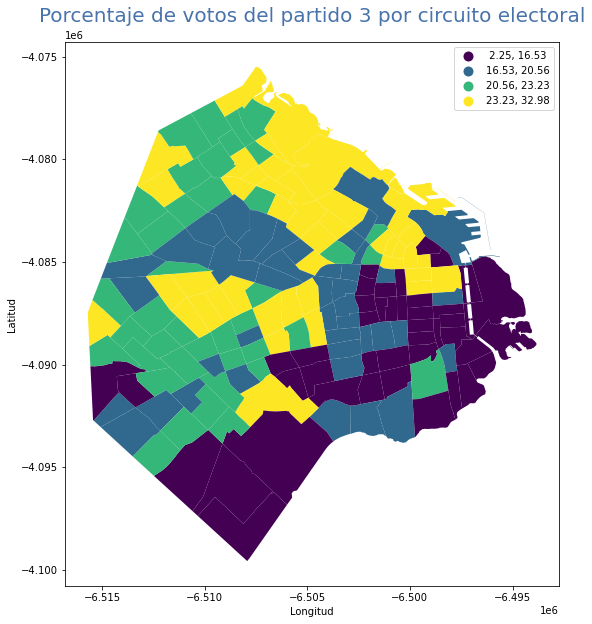

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Porcentaje de votos del partido 3 por circuito electoral', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
 
# Mostrar el mapa finalizado
caba_votos_shp.plot(column='pp3', cmap='viridis',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

<AxesSubplot:title={'center':'Porcentaje de votos del partido 2 por circuito electoral'}, xlabel='Longitud', ylabel='Latitud'>

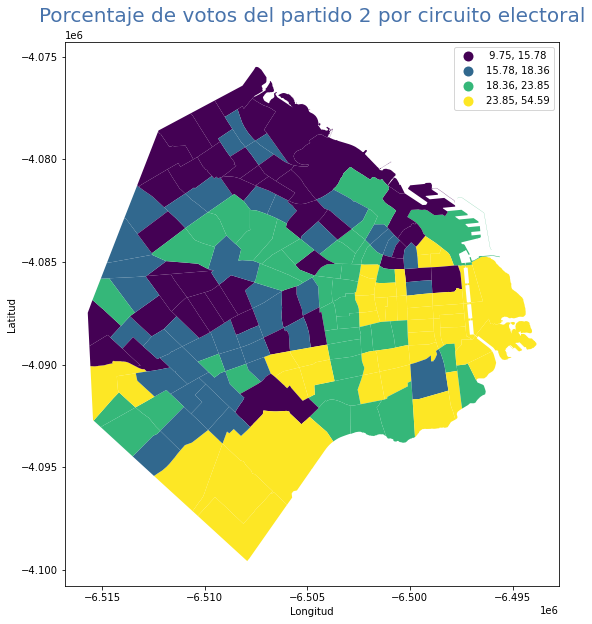

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Porcentaje de votos del partido 2 por circuito electoral', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
 
# Mostrar el mapa finalizado
caba_votos_shp.plot(column='pp2', cmap='viridis',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Análisis de variables sociodemográficas.

Con los fines de comparar estos resultados electorales con las variables sociodemográficas estructurales, y así poder arribar a un perfil de votantes del partido 3, es que pasamos a analizar la distribución de estas variables en CABA. Para esto, necesitamos de un nuevo geodataframe que nos permita visualizar los resultados del censo por radio censal.

In [23]:
radios_shp = gpd.read_file(r"C:\Users\ivanl\OneDrive\Escritorio\VSCode\Codgeo_CABA_con_datos\CABA_radios.shp",
    delimiter=',',       # delimitador ',',';','|','\t'
    header=0,            # número de fila como nombre de columna
    names=None,          # nombre de las columnas (ojo con header)
    index_col=0,         # que col es el índice
    usecols=None,        # que col usar. Ej: [0, 1, 2], ['foo', 'bar', 'baz']
    dtype=None,          # Tipo de col {'a': np.int32, 'b': str} 
    skiprows=None,       # saltear filas al inicio
    skipfooter=0,        # saltear filas al final
    nrows=None,          # n de filas a leer
    decimal='.',         # separador de decimal. Ej: ',' para EU dat
    quotechar='"',       # char para reconocer str
    encoding=None,
      )

radios_shp.rename({"DPTO" : "COMUNA"}, axis = 1, inplace = True) #cambie el nombre de la columna dpto por comuna para poder hacer un merge con el df que veniamos trabajando
radios_shp["COMUNA"] = radios_shp.COMUNA.str.strip("Comuna") #para sacarle la leyenda "Comuna" a la fila de comunas y que quede solo el numero
radios_shp["COMUNA"] = radios_shp["COMUNA"].apply(int)
radios_shp

RADIO  VULNERABIL       NSE CENTRO_DE_            HOSPITAL  \
0     020010101    0.802284 -0.456724     16.348              38.006   
1     020010201    0.817588 -0.456724     16.976               46.61   
2     020010202    0.820031 -0.456724     18.384              48.838   
3     020010203    0.818413 -0.456724     14.448              48.746   
4     020010204    0.825755 -0.456724     11.074  50.410000000000004   
...         ...         ...       ...        ...                 ...   
3548  020152109    0.082985  0.455652      9.706              12.128   
3549  020152110    0.073872  0.520911       7.61              13.622   
3550  020152111    0.076228  0.530775      8.342              14.754   
3551  020152112    0.193413  0.306683      9.968              17.104   
3552  020152113    0.147968  0.460590     10.548               16.83   

     POSTA_SANI IDPROV                             PROV IDDPTO  COMUNA  \
0        105.48     02  Ciudad Autónoma de Buenos Aires  02001       1   
1       133.978     02  Ciudad Autónoma de Buenos Aires  02001       1   
2       135.066     02  Ciudad Autónoma de Buenos Aires  02001       1   
3       131.126     02  Ciudad Autónoma de Buenos Aires  02001       1   
4       121.272     02  Ciudad Autónoma de Buenos Aires  02001       1   
...         ...    ...                              ...    ...     ...   
3548     112.78     02  Ciudad Autónoma de Buenos Aires  02015      15   
3549    113.328     02  Ciudad Autónoma de Buenos Aires  02015      15   
3550    113.234     02  Ciudad Autónoma de Buenos Aires  02015      15   
3551    113.058     02  Ciudad Autónoma de Buenos Aires  02015      15   
3552     113.03     02  Ciudad Autónoma de Buenos Aires  02015      15   

        REDCODE  RADIOS_POB  RADIOS_HOG  RADIOS_LAT  RADIOS_LON  RADIOS_SUP  \
0     020010101         336          65  -34.586689  -58.368836       1.794   
1     020010201         478         161  -34.578623  -58.386987       0.027   
2     020010202         401         128  -34.579194  -58.387533       0.018   
3     020010203         337         104  -34.580158  -58.385503       0.011   
4     020010204         602         163  -34.580006  -58.382654       0.136   
...         ...         ...         ...         ...         ...         ...   
3548  020152109         863         392  -34.599727  -58.431162       0.020   
3549  020152110         613         278  -34.598933  -58.430166       0.016   
3550  020152111         697         335  -34.598226  -58.429006       0.018   
3551  020152112         510         217  -34.597576  -58.427811       0.020   
3552  020152113         895         389  -34.597213  -58.425920       0.039   

                                               geometry  
0     POLYGON ((-58.37430 -34.57870, -58.36801 -34.5...  
1     POLYGON ((-58.38920 -34.57818, -58.38893 -34.5...  
2     POLYGON ((-58.38909 -34.57855, -58.38890 -34.5...  
3     POLYGON ((-58.38603 -34.57947, -58.38508 -34.5...  
4     POLYGON ((-58.38562 -34.57822, -58.38551 -34.5...  
...                                                 ...  
3548  POLYGON ((-58.43221 -34.59950, -58.43113 -34.5...  
3549  POLYGON ((-58.43113 -34.59880, -58.43006 -34.5...  
3550  POLYGON ((-58.43006 -34.59811, -58.42899 -34.5...  
3551  POLYGON ((-58.42899 -34.59743, -58.42784 -34.5...  
3552  POLYGON ((-58.42784 -34.59670, -58.42702 -34.5...  

[3553 rows x 17 columns]

A continuación, retomamos el dataframe con los resultados del censo de los votantes de CABA y le aplicamos una serie de operaciones para lograr unir los datos del censo con los radios censales.

In [24]:
votantes

COMUNA                                            NOMDPTO  \
0             1  Comuna 01                                     ...   
1             1  Comuna 01                                     ...   
2             1  Comuna 01                                     ...   
3             1  Comuna 01                                     ...   
4             1  Comuna 01                                     ...   
...         ...                                                ...   
2890146      15  Comuna 15                                     ...   
2890147      15  Comuna 15                                     ...   
2890148      15  Comuna 15                                     ...   
2890149      15  Comuna 15                                     ...   
2890150      15  Comuna 15                                     ...   

         FRAC_REF_ID  IDFRAC  RADIO_REF_ID  IDRADIO  VIVIENDA_REF_ID  TIPVV  \
0                  1       1             1        1                1      1   
1                  1       1             1        1                1      1   
2                  1       1             1        1                1      1   
3                  1       1             1        1                1      1   
4                  1       1             1        1                1      1   
...              ...     ...           ...      ...              ...    ...   
2890146          351      21          3553       13          1426438      2   
2890147          351      21          3553       13          1426438      2   
2890148          351      21          3553       13          1426438      2   
2890149          351      21          3553       13          1426438      2   
2890150          351      21          3553       13          1426438      2   

         V01  V02  ...  P05  P06  P07  P12  EDADAGRU  EDADQUI  P08  P09 P10  \
0          1    1  ...    1    0    1    2         2       13    2    4   2   
1          1    1  ...    1    0    1    1         2       10    2    4   1   
2          1    1  ...    1    0    1    1         3       14    2    7   2   
3          1    1  ...    1    0    1    1         2       13    2    6   1   
4          1    1  ...    2  221    1    1         2        5    1    4   2   
...      ...  ...  ...  ...  ...  ...  ...       ...      ...  ...  ...  ..   
2890146    0    0  ...    1    0    1    0         3       20    2    2   1   
2890147    0    0  ...    1    0    1    0         3       19    2    6   1   
2890148    0    0  ...    1    0    1    0         3       17    2    2   1   
2890149    0    0  ...    1    0    1    0         3       18    2    2   1   
2890150    0    0  ...    1    0    1    0         3       19    2    2   1   

         CONDACT  
0              1  
1              1  
2              1  
3              3  
4              1  
...          ...  
2890146        0  
2890147        0  
2890148        0  
2890149        0  
2890150        0  

[2325119 rows x 55 columns]

In [25]:
votantes["PROV"] = 2
votantes
# %%
votantes["COMUNA"] = votantes["COMUNA"].apply(str)
votantes["COMUNA"]
# %%
votantes["IDFRAC"] = votantes["IDFRAC"].apply(str)
# %%
votantes["IDRADIO"] = votantes["IDRADIO"].apply(str)

# %%
votantes["PROV"] = votantes["PROV"].apply(str)
# %%
votantes["COMUNA"] = votantes["COMUNA"].str.pad(3, side = "left", fillchar ='0')
votantes["COMUNA"]
# %%
votantes["IDFRAC"] = votantes["IDFRAC"].str.pad(2, side = "left", fillchar ='0')
votantes["IDFRAC"]
# %%
votantes["IDRADIO"] = votantes["IDRADIO"].str.pad(2, side = "left", fillchar ='0')
votantes["IDRADIO"]

# %%
votantes["PROV"] = votantes["PROV"].str.pad(2, side = "left", fillchar ='0')
votantes["PROV"]
# %%
votantes
# %%
votantes["RADIO"] = votantes.PROV.str.cat(votantes.COMUNA)
votantes
# %%
votantes["RADIO"] = votantes.RADIO.str.cat(votantes.IDFRAC)
votantes
# %%
votantes["RADIO"] = votantes.RADIO.str.cat(votantes.IDRADIO)
votantes

C:\Users\ivanl\AppData\Local\Temp\ipykernel_8644\837075708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votantes["PROV"] = 2
C:\Users\ivanl\AppData\Local\Temp\ipykernel_8644\837075708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votantes["COMUNA"] = votantes["COMUNA"].apply(str)
C:\Users\ivanl\AppData\Local\Temp\ipykernel_8644\837075708.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

COMUNA                                            NOMDPTO  \
0          001  Comuna 01                                     ...   
1          001  Comuna 01                                     ...   
2          001  Comuna 01                                     ...   
3          001  Comuna 01                                     ...   
4          001  Comuna 01                                     ...   
...        ...                                                ...   
2890146    015  Comuna 15                                     ...   
2890147    015  Comuna 15                                     ...   
2890148    015  Comuna 15                                     ...   
2890149    015  Comuna 15                                     ...   
2890150    015  Comuna 15                                     ...   

         FRAC_REF_ID IDFRAC  RADIO_REF_ID IDRADIO  VIVIENDA_REF_ID  TIPVV  \
0                  1     01             1      01                1      1   
1                  1     01             1      01                1      1   
2                  1     01             1      01                1      1   
3                  1     01             1      01                1      1   
4                  1     01             1      01                1      1   
...              ...    ...           ...     ...              ...    ...   
2890146          351     21          3553      13          1426438      2   
2890147          351     21          3553      13          1426438      2   
2890148          351     21          3553      13          1426438      2   
2890149          351     21          3553      13          1426438      2   
2890150          351     21          3553      13          1426438      2   

         V01  V02  ...  P07  P12  EDADAGRU  EDADQUI  P08  P09  P10  CONDACT  \
0          1    1  ...    1    2         2       13    2    4    2        1   
1          1    1  ...    1    1         2       10    2    4    1        1   
2          1    1  ...    1    1         3       14    2    7    2        1   
3          1    1  ...    1    1         2       13    2    6    1        3   
4          1    1  ...    1    1         2        5    1    4    2        1   
...      ...  ...  ...  ...  ...       ...      ...  ...  ...  ...      ...   
2890146    0    0  ...    1    0         3       20    2    2    1        0   
2890147    0    0  ...    1    0         3       19    2    6    1        0   
2890148    0    0  ...    1    0         3       17    2    2    1        0   
2890149    0    0  ...    1    0         3       18    2    2    1        0   
2890150    0    0  ...    1    0         3       19    2    2    1        0   

        PROV      RADIO  
0         02  020010101  
1         02  020010101  
2         02  020010101  
3         02  020010101  
4         02  020010101  
...      ...        ...  
2890146   02  020152113  
2890147   02  020152113  
2890148   02  020152113  
2890149   02  020152113  
2890150   02  020152113  

[2325119 rows x 57 columns]

Una vez que unimos estos dataframe, podemos pasar a analizar la distribución de ciertas variables que consideramos de interés.

Para poder calcular los porcentajes de cada variable por radio es fundamental asignar a una variable el total de personas por radio.

In [26]:
votantes.columns

Index(['COMUNA', 'NOMDPTO', 'FRAC_REF_ID', 'IDFRAC', 'RADIO_REF_ID', 'IDRADIO',
       'VIVIENDA_REF_ID', 'TIPVV', 'V01', 'V02', 'V00', 'URP', 'INCALSERV',
       'INMAT', 'MUNI', 'LOCAL', 'INCALCONS', 'TOTHOG', '_merge',
       'HOGAR_REF_ID', 'NHOG', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11',
       'H12', 'H13', 'H14', 'H15', 'H16', 'H19A', 'H19B', 'H19C', 'H19D',
       'PROP', 'INDHAC', 'TOTPERS', 'ALGUNBI', 'PERSONA_REF_ID', 'P01', 'P02',
       'P03', 'P05', 'P06', 'P07', 'P12', 'EDADAGRU', 'EDADQUI', 'P08', 'P09',
       'P10', 'CONDACT', 'PROV', 'RADIO'],
      dtype='object')

In [27]:
totpersxradio = votantes[["RADIO","TOTPERS"]].groupby(["RADIO"]).count()
totpersxradio

TOTPERS
RADIO             
020010101      273
020010201      308
020010202      239
020010203      209
020010204      358
...            ...
020152109      723
020152110      501
020152111      579
020152112      420
020152113      759

[3552 rows x 1 columns]

Ahora sí, en primer lugar, vamos a analizar la distribución de estudiantes universitarios en CABA. Para facilitar la interpretación realizamos una división en quantiles donde cada color demuestra donde se encuentra el 25% de la población.

In [28]:
universitario = votantes.loc[(votantes["P09"] == 7)]
universitario = universitario.loc[:,["P09", "RADIO"]]
universitario = universitario.groupby(["RADIO"]).count()
universitario.reset_index(inplace= True)
universitario = pd.merge(universitario, totpersxradio, on = "RADIO", how = "inner")
universitario 
# %%
universitario["% sobre totpers x radio"] = universitario.apply(
    (lambda x: (x["P09"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
universitario


RADIO  P09  TOTPERS  % sobre totpers x radio
0     020010101   36      273                13.186813
1     020010201   18      308                 5.844156
2     020010202    8      239                 3.347280
3     020010203   15      209                 7.177033
4     020010204   23      358                 6.424581
...         ...  ...      ...                      ...
3546  020152109  274      723                37.897649
3547  020152110  197      501                39.321357
3548  020152111  243      579                41.968912
3549  020152112  107      420                25.476190
3550  020152113  242      759                31.884058

[3551 rows x 4 columns]

<AxesSubplot: title={'center': 'Universitarios'}, xlabel='Longitud', ylabel='Latitud'>

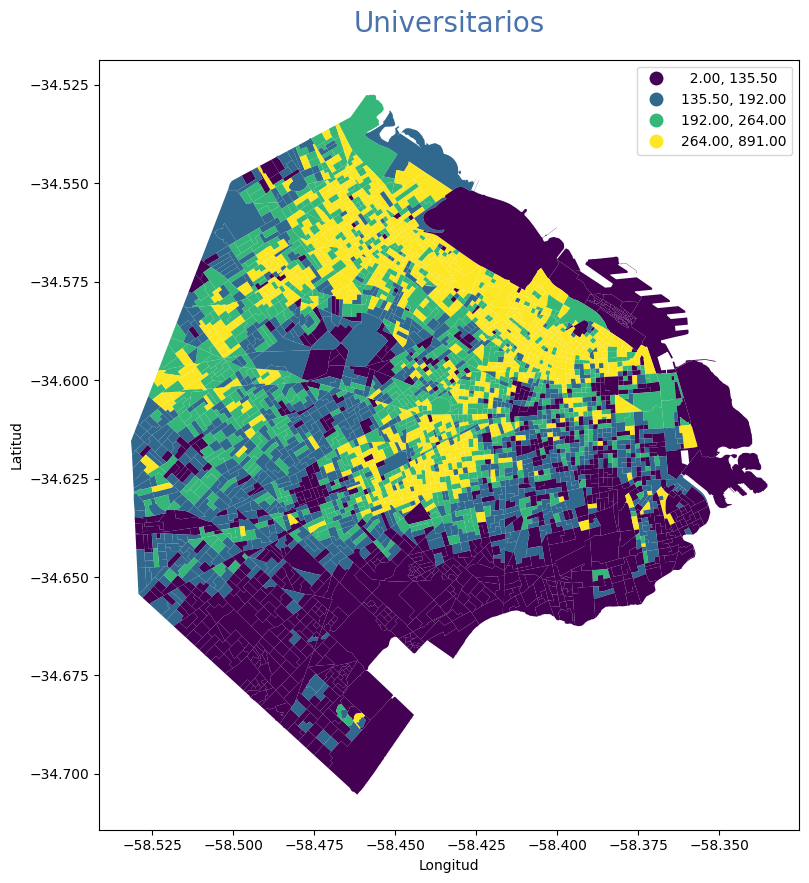

In [29]:
uni_radio_shp = pd.merge(radios_shp,universitario, on="RADIO", how="inner")
uni_radio_shp
# %%
fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Universitarios', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
uni_radio_shp.plot(column='P09', cmap='viridis',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Analizando la distribución de estudiantes universitarios en CABA, podemos intentar profundizar el análisis y visualizar la distribución de personas que eectivamente terminaron el nivel universitario de educación.  

In [30]:
termino_universidad = votantes.loc[((votantes["P09"] == 7) & (votantes["P10"] == 1))] #Seleccionamos a los que terminaron univerisdad

termino_universidad = termino_universidad.loc[:,["P09", "P10", "RADIO"]]
termino_universidad

# %%
termino_universidad = termino_universidad.groupby(["RADIO"]).count()
termino_universidad
# %%
termino_universidad.reset_index(inplace= True)
termino_universidad

# %%
termino_universidad = pd.merge(termino_universidad, totpersxradio, on = "RADIO", how = "inner")
termino_universidad 
# %%
termino_universidad["% sobre totpers x radio"] = termino_universidad.apply(
    (lambda x: (x["P09"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
termino_universidad

RADIO  P09  P10  TOTPERS  % sobre totpers x radio
0     020010101   11   11      273                 4.029304
1     020010201    7    7      308                 2.272727
2     020010202    2    2      239                 0.836820
3     020010203    3    3      209                 1.435407
4     020010204    1    1      358                 0.279330
...         ...  ...  ...      ...                      ...
3544  020152109  123  123      723                17.012448
3545  020152110  112  112      501                22.355289
3546  020152111  163  163      579                28.151986
3547  020152112   56   56      420                13.333333
3548  020152113  126  126      759                16.600791

[3549 rows x 5 columns]

<AxesSubplot: title={'center': 'Termino la universidad'}, xlabel='Longitud', ylabel='Latitud'>

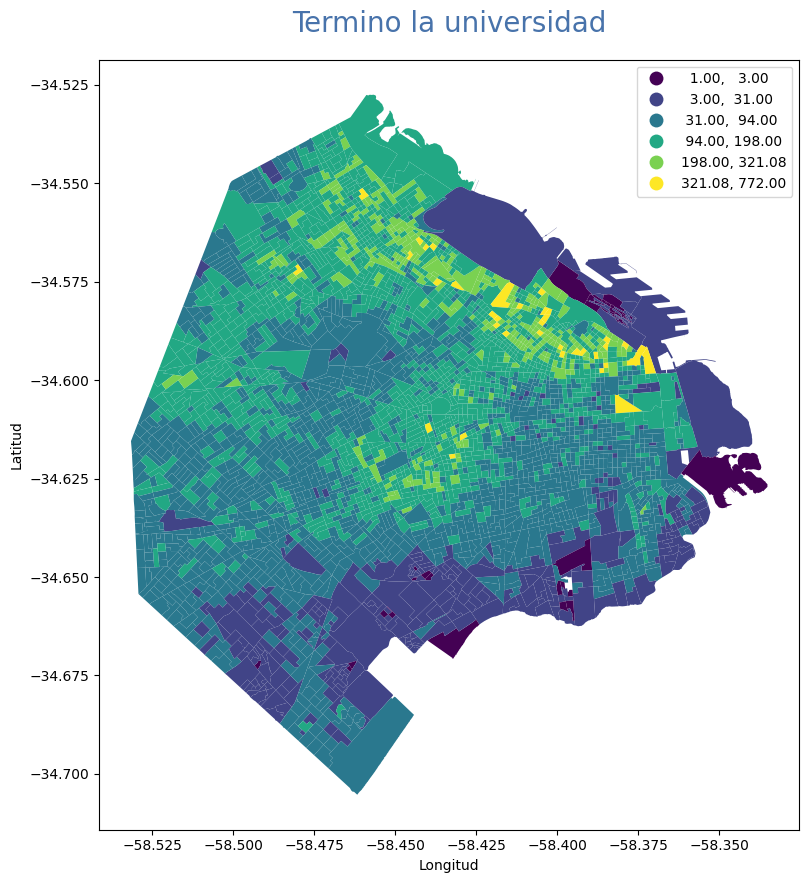

In [32]:
recibido_radio_shp = pd.merge(radios_shp,termino_universidad, on="RADIO", how="inner")
recibido_radio_shp

fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Termino la universidad', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
recibido_radio_shp.plot(column='P09', scheme='percentiles', k = 4, legend=True, ax=ax, zorder=5)

A continuación, vamos a analizar la distribución de personas que no terminaron el nivel secundario de educación en CABA y tienen más de 20 años.

In [33]:
no_secundario = votantes.loc[((votantes["P09"] == 4) & (votantes["P10"] == 2) & (votantes["P03"] >20 ))] 

no_secundario = no_secundario.loc[:,["P09", "P10", "RADIO"]]
no_secundario

# %%
no_secundario = no_secundario.groupby(["RADIO"]).count()
no_secundario
# %%
no_secundario.reset_index(inplace= True)
no_secundario

# %%
no_secundario = pd.merge(no_secundario, totpersxradio, on = "RADIO", how = "inner")
no_secundario 

# %%
no_secundario["% sobre totpers x radio"] = no_secundario.apply(
    (lambda x: (x["P09"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
no_secundario

RADIO  P09  P10  TOTPERS  % sobre totpers x radio
0     020010101   31   31      273                11.355311
1     020010201   65   65      308                21.103896
2     020010202   51   51      239                21.338912
3     020010203   42   42      209                20.095694
4     020010204   90   90      358                25.139665
...         ...  ...  ...      ...                      ...
3547  020152109   58   58      723                 8.022130
3548  020152110   39   39      501                 7.784431
3549  020152111   29   29      579                 5.008636
3550  020152112   54   54      420                12.857143
3551  020152113   62   62      759                 8.168643

[3552 rows x 5 columns]

<AxesSubplot: title={'center': 'No terminaron el secundario y tienen más de 20'}, xlabel='Longitud', ylabel='Latitud'>

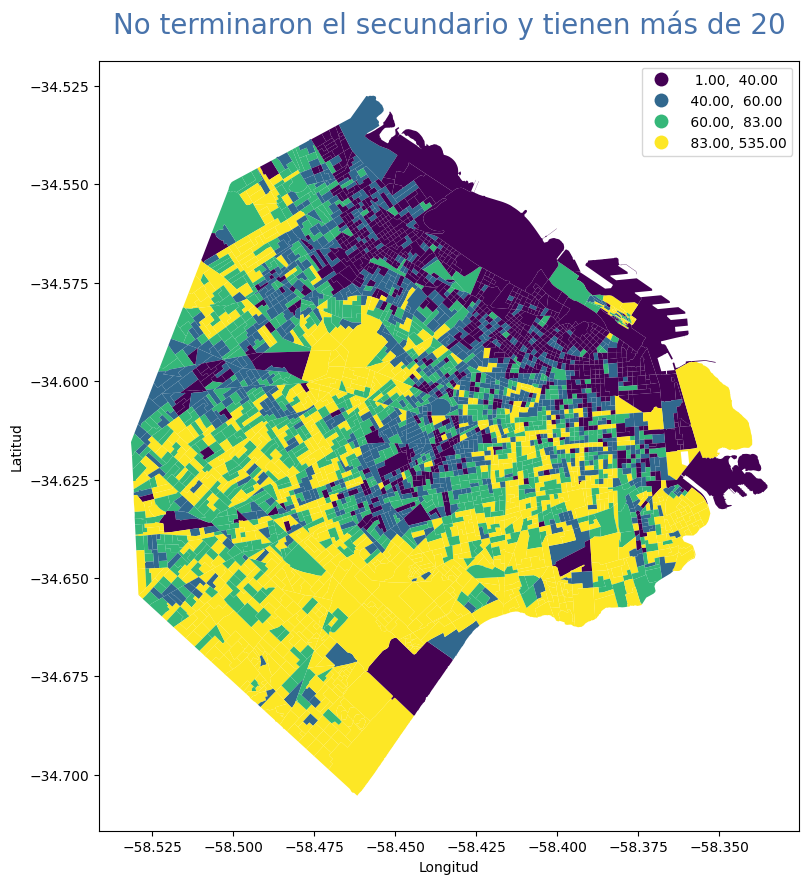

In [34]:
nosec_radio_shp = pd.merge(radios_shp,no_secundario, on="RADIO", how="inner")
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('No terminaron el secundario y tienen más de 20', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
nosec_radio_shp.plot(column='P09',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Continuando con el análisis sobre el nivel educativo, pasamos a analizar la distribución de personas que únicamente cursaron el nivel primario.

In [35]:
primario_ = votantes.loc[:,"P09"] == 2
primario = votantes[primario_]

primario = primario.loc[:,["P09", "RADIO"]]
primario

# %%
primario = primario.groupby(["RADIO"]).count()
primario
# %%
primario.reset_index(inplace= True)
primario

# %%
primario = pd.merge(primario, totpersxradio, on = "RADIO", how = "inner")
primario 

# %%
primario["% sobre totpers x radio"] = primario.apply(
    (lambda x: (x["P09"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
primario

RADIO  P09  TOTPERS  % sobre totpers x radio
0     020010101   50      273                18.315018
1     020010201  117      308                37.987013
2     020010202  105      239                43.933054
3     020010203   71      209                33.971292
4     020010204  122      358                34.078212
...         ...  ...      ...                      ...
3547  020152109   89      723                12.309820
3548  020152110   61      501                12.175649
3549  020152111   61      579                10.535406
3550  020152112   69      420                16.428571
3551  020152113  109      759                14.361001

[3552 rows x 4 columns]

<AxesSubplot:title={'center':'Únicamente nivel de educación primaria'}, xlabel='Longitud', ylabel='Latitud'>

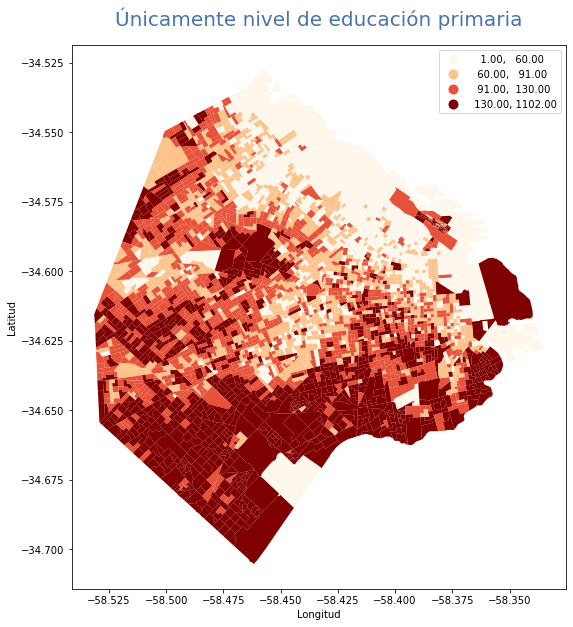

In [ ]:
prim_radio_shp = pd.merge(radios_shp,primario, on="RADIO", how="inner")


fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Únicamente nivel de educación primaria', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
prim_radio_shp.plot(column='P09', cmap='OrRd',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Luego analizamos donde se encuentran los hogares con hacinamiento, considerando a los mismos como los que tienen más de 2 personas por habitación.

In [36]:
hacinado_ = votantes.loc[:,"INDHAC"] == 6
hacinados = votantes[hacinado_]
hacinados
 

hacinados = hacinados.loc[:,["INDHAC", "RADIO"]]
hacinados

# %%
hacinados = hacinados.groupby(["RADIO"]).count()
hacinados
# %%
hacinados.reset_index(inplace= True)
hacinados

# %%
hacinados = pd.merge(hacinados, totpersxradio, on = "RADIO", how = "inner")
hacinados 

# %%
hacinados["% sobre totpers x radio"] = hacinados.apply(
    (lambda x: (x["INDHAC"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
hacinados

RADIO  INDHAC  TOTPERS  % sobre totpers x radio
0     020010101      64      273                23.443223
1     020010201      31      308                10.064935
2     020010202      47      239                19.665272
3     020010203      19      209                 9.090909
4     020010204      32      358                 8.938547
...         ...     ...      ...                      ...
2754  020152109       2      723                 0.276625
2755  020152110       7      501                 1.397206
2756  020152111      11      579                 1.899827
2757  020152112      32      420                 7.619048
2758  020152113      14      759                 1.844532

[2759 rows x 4 columns]

<AxesSubplot: title={'center': 'Hacinados'}, xlabel='Longitud', ylabel='Latitud'>

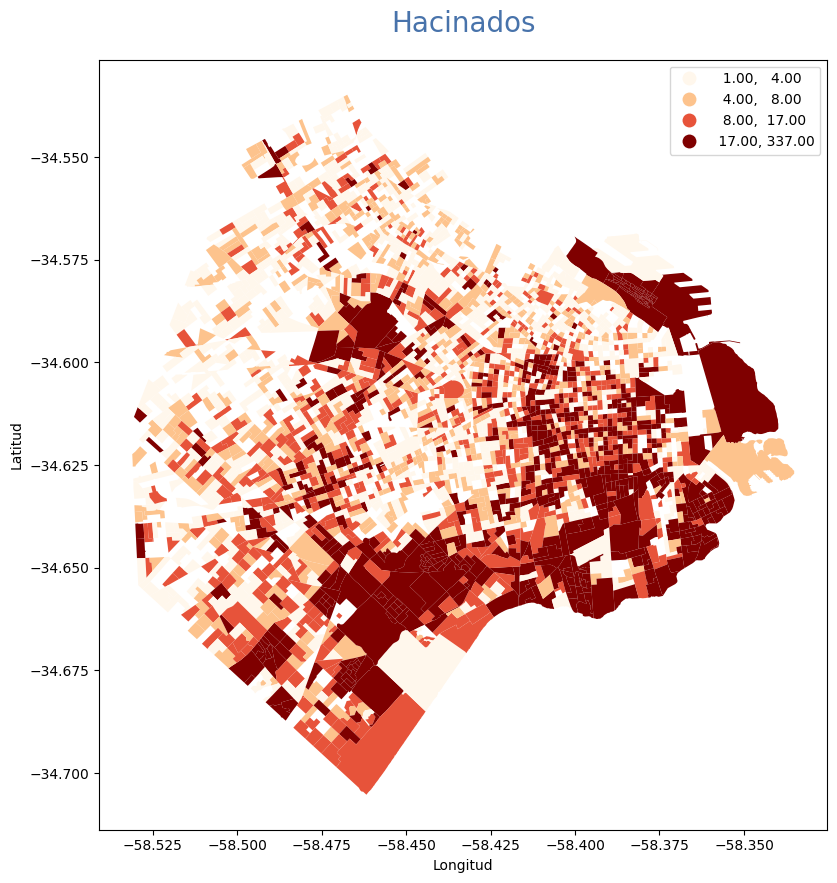

In [37]:
# %%
hac_radio_shp = pd.merge(radios_shp,hacinados, on="RADIO", how="inner")
hac_radio_shp

fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Hacinados', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
hac_radio_shp.plot(column='INDHAC', cmap='OrRd',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Pasamos a analizar la distribución de personas jóvenes, entre 18 y 30 años.

In [38]:
jovenes_ = votantes.loc[:,"P03"] < 30
jovenes = votantes[jovenes_]

jovenes = jovenes.loc[:,["P03", "RADIO"]]
jovenes

# %%
jovenes = jovenes.groupby(["RADIO"]).count()
jovenes
# %%
jovenes.reset_index(inplace= True)
jovenes

# %%
jovenes = pd.merge(jovenes, totpersxradio, on = "RADIO", how = "inner")
jovenes 

# %%
jovenes["% sobre totpers x radio"] = jovenes.apply(
    (lambda x: (x["P03"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
jovenes

RADIO  P03  TOTPERS  % sobre totpers x radio
0     020010101  104      273                38.095238
1     020010201  136      308                44.155844
2     020010202  105      239                43.933054
3     020010203   89      209                42.583732
4     020010204  159      358                44.413408
...         ...  ...      ...                      ...
3547  020152109  164      723                22.683264
3548  020152110  103      501                20.558882
3549  020152111  133      579                22.970639
3550  020152112  110      420                26.190476
3551  020152113  181      759                23.847167

[3552 rows x 4 columns]

<AxesSubplot: title={'center': 'Jóvenes de 18 a 30 '}, xlabel='Longitud', ylabel='Latitud'>

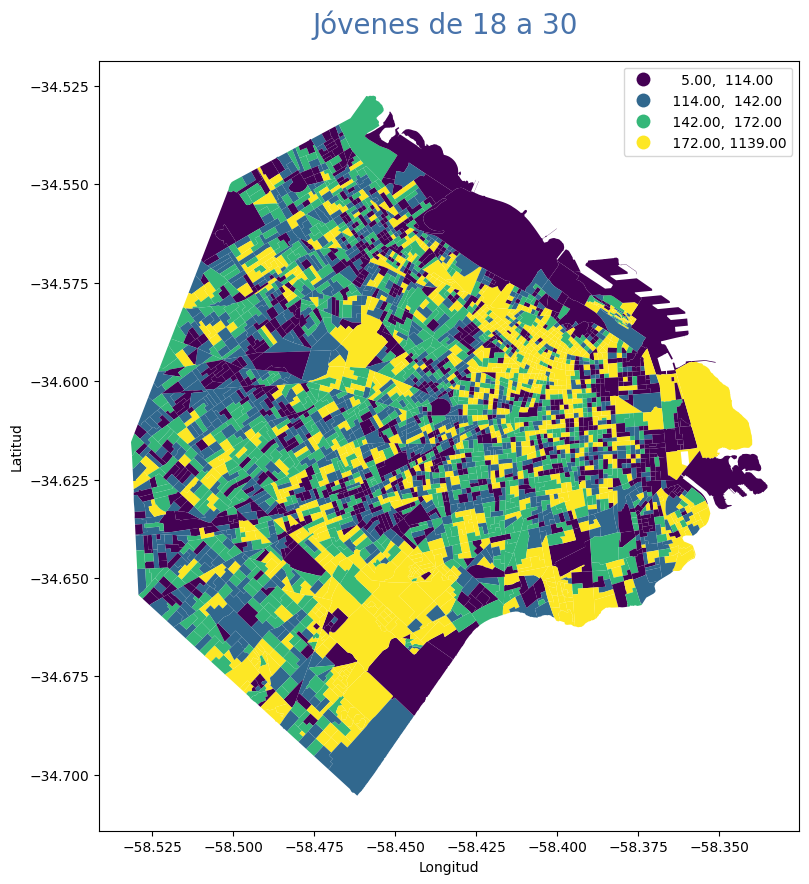

In [39]:
jov_radio_shp = pd.merge(radios_shp,jovenes, on="RADIO", how="inner")


fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Jóvenes de 18 a 30 ', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
jov_radio_shp.plot(column='P03',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Ahora, analizamos la distribución de personas mayores de 55 años.

In [40]:
nojovenes_ = votantes.loc[:,"P03"] > 55
nojovenes = votantes[nojovenes_]

nojovenes = nojovenes.loc[:,["P03", "RADIO"]]
nojovenes

# %%
nojovenes = nojovenes.groupby(["RADIO"]).count()
nojovenes
# %%
nojovenes.reset_index(inplace= True)
nojovenes

# %%
nojovenes = pd.merge(nojovenes, totpersxradio, on = "RADIO", how = "inner")
nojovenes 

# %%
nojovenes["% sobre totpers x radio"] = nojovenes.apply(
    (lambda x: (x["P03"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
nojovenes

RADIO  P03  TOTPERS  % sobre totpers x radio
0     020010101   24      273                 8.791209
1     020010201   30      308                 9.740260
2     020010202   24      239                10.041841
3     020010203   20      209                 9.569378
4     020010204   35      358                 9.776536
...         ...  ...      ...                      ...
3547  020152109  238      723                32.918396
3548  020152110  153      501                30.538922
3549  020152111  159      579                27.461140
3550  020152112  120      420                28.571429
3551  020152113  248      759                32.674572

[3552 rows x 4 columns]

<AxesSubplot: title={'center': 'Mayores de 55'}, xlabel='Longitud', ylabel='Latitud'>

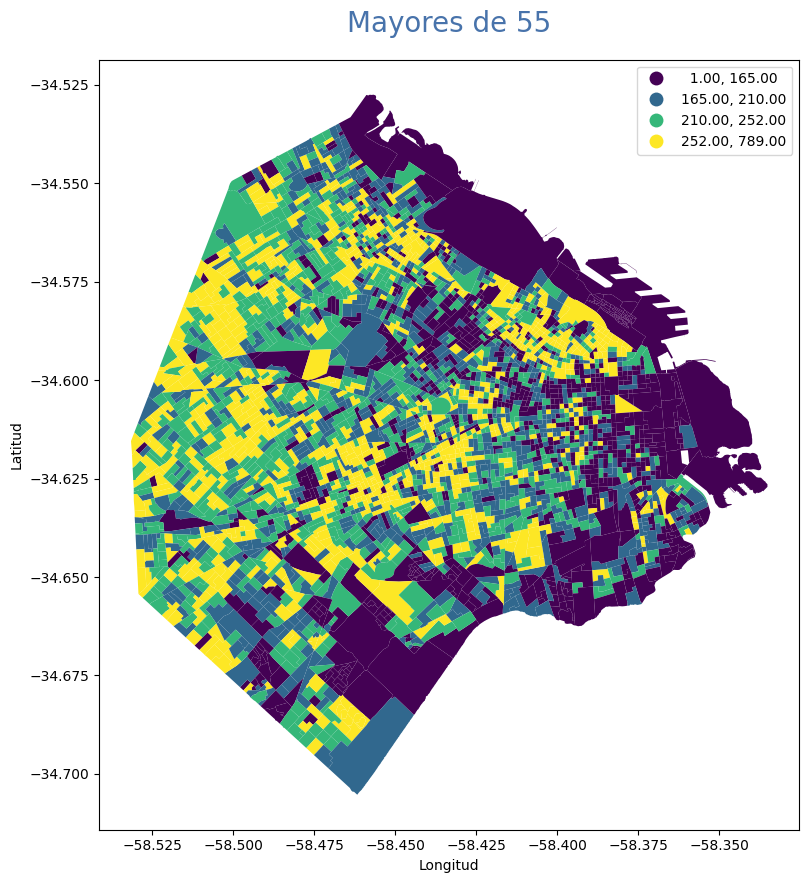

In [41]:
njov_radio_shp = pd.merge(radios_shp,nojovenes, on="RADIO", how="inner")


fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Mayores de 55', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
njov_radio_shp.plot(column='P03',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Ahora, pasamos a analizar la distribución de desempleados por radios censales en CABA.

In [42]:
is_desempleado = votantes.loc[:,"CONDACT"] == 2
desempleados = votantes[is_desempleado]

desempleados = desempleados.loc[:,["CONDACT", "RADIO"]]
desempleados

# %%
desempleados = desempleados.groupby(["RADIO"]).count()
desempleados
# %%
desempleados.reset_index(inplace= True)
desempleados

# %%
desempleados = pd.merge(desempleados, totpersxradio, on = "RADIO", how = "inner")
desempleados 

# %%
desempleados["% sobre totpers x radio"] = desempleados.apply(
    (lambda x: (x["CONDACT"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
desempleados

RADIO  CONDACT  TOTPERS  % sobre totpers x radio
0     020010101        7      273                 2.564103
1     020010201       11      308                 3.571429
2     020010202       14      239                 5.857741
3     020010203       15      209                 7.177033
4     020010204       18      358                 5.027933
...         ...      ...      ...                      ...
3543  020152109       20      723                 2.766252
3544  020152110       12      501                 2.395210
3545  020152111       15      579                 2.590674
3546  020152112       13      420                 3.095238
3547  020152113       26      759                 3.425560

[3548 rows x 4 columns]

<AxesSubplot: title={'center': 'Desempleados'}, xlabel='Longitud', ylabel='Latitud'>

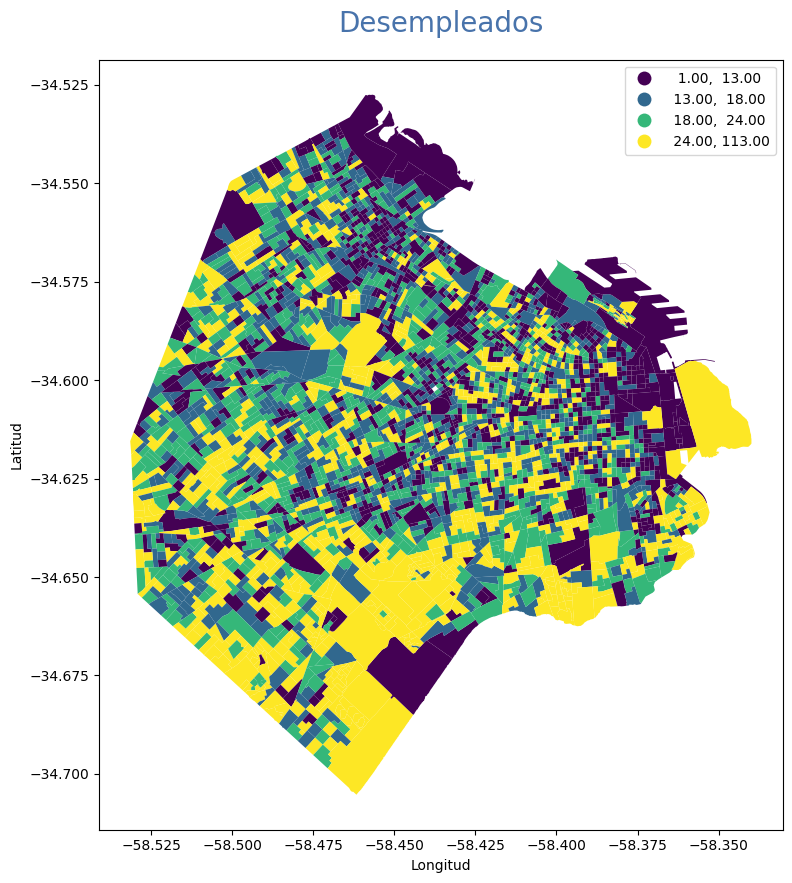

In [43]:
des_radio_shp = pd.merge(radios_shp,desempleados, on="RADIO", how="inner")

fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Desempleados', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
des_radio_shp.plot(column='CONDACT',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Vamos a graficar el total de personas por circuito electoral.

DESDE ACÁ EMPEZAMOS A GRAFICAR POR CIRCUITO

C:\Users\ivanl\AppData\Local\Temp\ipykernel_8644\2960690536.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  votantes_agrup2["geometry"] = votantes_agrup2.centroid
c:\Users\ivanl\OneDrive\Escritorio\VSCode\NumpyPandas\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot: >

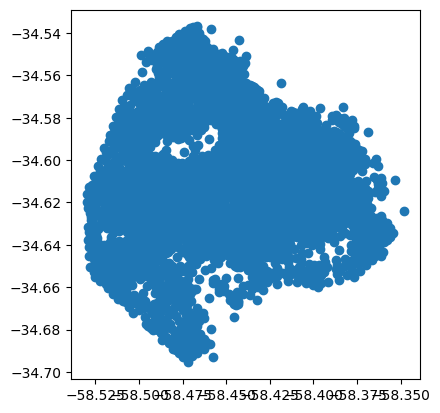

In [44]:
votantes_agrup_radio_shp = votantes.groupby(["RADIO"]).count() #Acá pusimos un .count() y funciono bien, lo único que nos unia a todas las variables, es decir que en las comunas nos las agrupaba y las contaba
votantes_agrup_radio_shp

votantes_agrup_radio_shp = pd.merge(radios_shp,votantes_agrup_radio_shp, on="RADIO", how="inner") #Primero asociamos nuestras variables del censo a la información georeferenciada
votantes_agrup2 = votantes_agrup_radio_shp[["RADIO","geometry"]]
votantes_agrup2["geometry"] = votantes_agrup2.centroid
votantes_agrup2 = votantes_agrup2[["geometry", "RADIO"]]
votantes_centroide_shp = votantes_agrup2
votantes_centroide_shp.plot()



<AxesSubplot: title={'center': 'Candidato 3'}, xlabel='Longitud', ylabel='Latitud'>

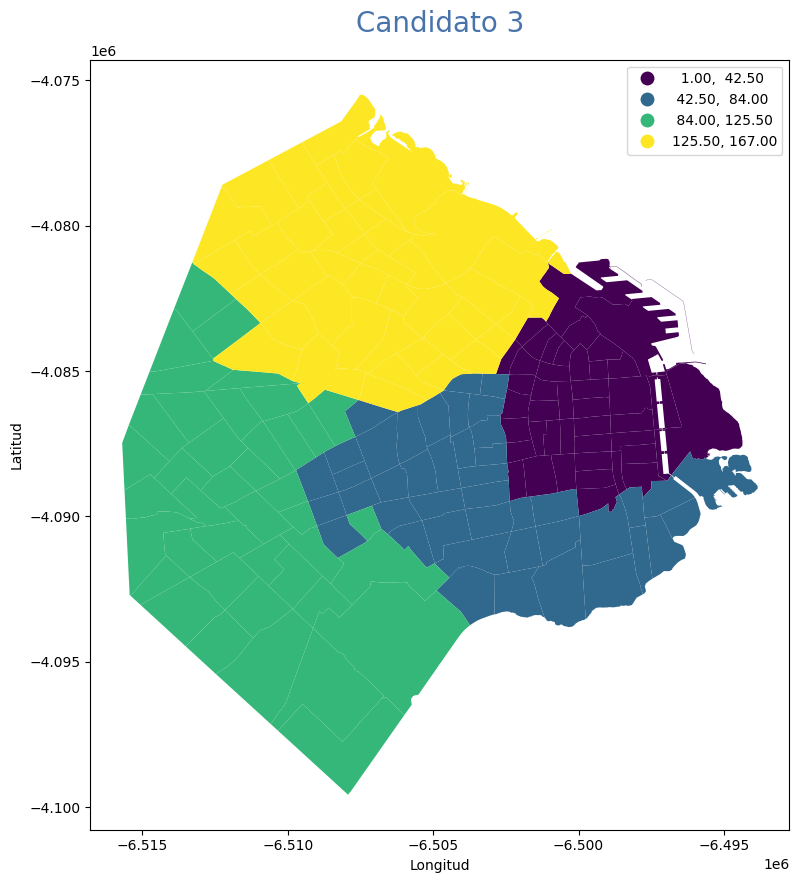

In [45]:

fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Candidato 3', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

caba_votos_shp.plot(column='circuito',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

In [50]:
votantes_centroide_shp = votantes_centroide_shp.to_crs(caba_votos_shp.crs) #ACÁ HACEMOS LA TABLA INTERMEDIA

Index(['index', 'distrito', 'provincia', 'departamen', 'cabecera', 'circuito',
       'indec_p', 'indec_d', 'geometry', 'COMUNA', 'pp1', 'pp2', 'pp3', 'pp4',
       'nv', 'total'],
      dtype='object')

In [54]:
join = gpd.sjoin(caba_votos_shp,votantes_centroide_shp, how = "inner", op = "contains") #CAmbiar nombre de caba
tabla_intermedia = join[["RADIO", "circuito",]]
tabla_intermedia

c:\Users\ivanl\OneDrive\Escritorio\VSCode\NumpyPandas\lib\site-packages\IPython\core\interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RADIO  circuito
0    020012511         1
0    020012609         1
0    020012510         1
0    020012608         1
0    020012509         1
..         ...       ...
166  020150103       167
166  020150106       167
166  020150107       167
166  020150109       167
166  020150108       167

[3549 rows x 2 columns]

Ya con la tabla intermedia podemos aislar variables desde votantes y después georeferenciarlas en base a los circuitos.

Lo primero que hacemos es crear una variable donde solo nos deje a la cantidad de casos que hay en cada radio [.count()].(Abajo podemos ver el ejemplo de la variable "universitario" agrupada por radios) 

In [55]:
universitario = votantes.loc[(votantes["P09"] == 7)]
universitario = universitario.loc[:,["P09", "RADIO"]]
universitario = universitario.groupby(["RADIO"]).count()
universitario.reset_index(inplace= True)
universitario


RADIO  P09
0     020010101   36
1     020010201   18
2     020010202    8
3     020010203   15
4     020010204   23
...         ...  ...
3546  020152109  274
3547  020152110  197
3548  020152111  243
3549  020152112  107
3550  020152113  242

[3551 rows x 2 columns]

Ahora tenemos que agrupar los radios segun en el circuito que estan. Para eso hacemos un merge de la tabla de universitarios con la tabla intermedia segun el radio. Asi nos queda la misma tabla de universitarios con una nueva columna que dice los "circuitos" que corresponden a ese radio.
Después agrupamos por circuito y SUMAMOS [.sum()] los casos que hay para despues poder graficarlsos.
Ahora bien, acá no contamos con el geometry del circuito, por lo que no podemos graficar aún, por eso la última linea hace un merge entre el numero circuito y el shp de ese circuito que encontramos en "caba_shp".
Ahora si, ploteamos y disfrutamos.

C:\Users\ivanl\AppData\Local\Temp\ipykernel_8644\464629915.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  universitario_x_circuito = universitario_x_circuito.groupby("circuito").sum()#SUMAR !! NO CONTAR


<AxesSubplot: title={'center': 'universitario x circuito'}, xlabel='Longitud', ylabel='Latitud'>

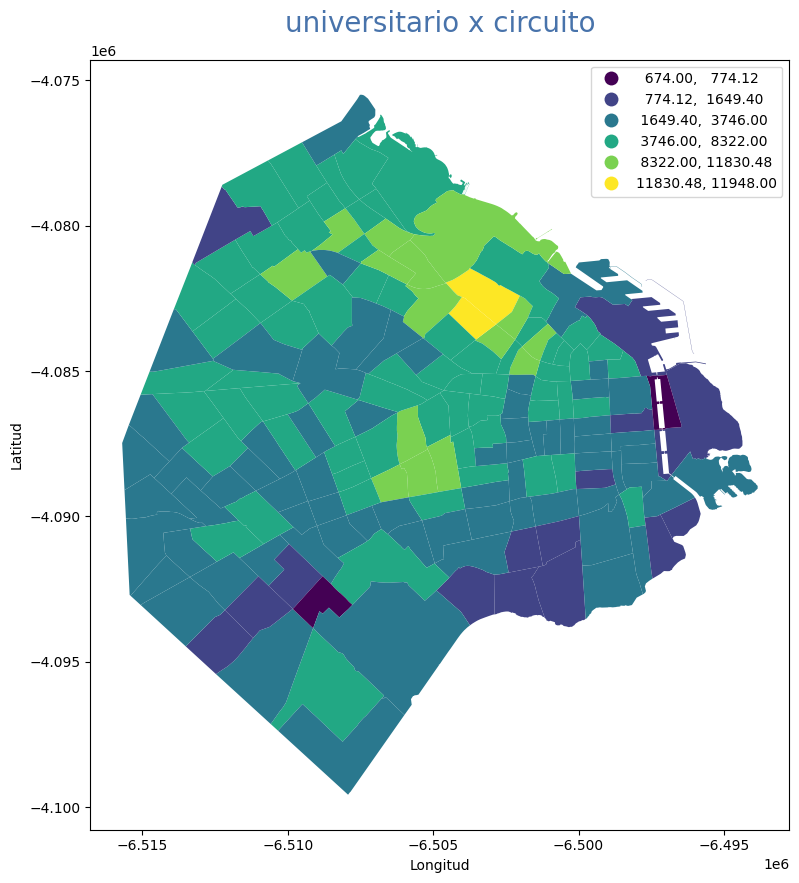

In [59]:
universitario_x_circuito = pd.merge(universitario,tabla_intermedia, how = "inner", on = "RADIO")
universitario_x_circuito = universitario_x_circuito.groupby("circuito").sum()#SUMAR !! NO CONTAR
universitario_x_circuito #ESTO NO TIENE LOS GEOMETRY
universitario_x_circuito = pd.merge(caba_shp,universitario_x_circuito, how = "inner", on = "circuito")


fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('universitario x circuito', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

universitario_x_circuito.plot(column='P09',scheme='percentiles', k = 4, legend=True, ax=ax, zorder=5)



In [60]:
universitario_x_circuito.sort_values(by="circuito",inplace=True)
universitario_x_circuito

distrito                        provincia departamen   cabecera  circuito  \
7         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         1   
8         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         2   
0         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         3   
16        01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         4   
5         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         5   
..       ...                              ...        ...        ...       ...   
161       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       163   
157       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       164   
152       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       165   
153       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       166   
154       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       167   

    indec_p indec_d                                           geometry   P09  
7        02     001  POLYGON Z ((-6497294.216 -4088142.493 0.000, -...  2755  
8        02     001  POLYGON Z ((-6498537.655 -4087740.684 0.000, -...  2882  
0        02     001  POLYGON Z ((-6496304.252 -4084732.697 0.000, -...   802  
16       02     001  POLYGON Z ((-6497398.411 -4087025.705 0.000, -...   674  
5        02     001  MULTIPOLYGON Z (((-6497185.903 -4082052.692 0....  1641  
..      ...     ...                                                ...   ...  
161      02     015  POLYGON Z ((-6505348.070 -4083866.211 0.000, -...  3188  
157      02     015  POLYGON Z ((-6507652.050 -4084945.661 0.000, -...  3114  
152      02     015  POLYGON Z ((-6508638.340 -4081745.040 0.000, -...  5633  
153      02     015  POLYGON Z ((-6508941.686 -4083702.129 0.000, -...  4022  
154      02     015  POLYGON Z ((-6509514.870 -4084304.493 0.000, -...  3564  

[167 rows x 9 columns]

Vamos a estudiar la correlacion entre voto y uso de la tenologia:

In [82]:
compu_ = votantes.loc[:,"P12"] == 1
compu = votantes[compu_]
compu
 

compu = compu.loc[:,["P12", "RADIO"]]
compu

# %%
compu = compu.groupby(["RADIO"]).count()
compu
# %%
compu.reset_index(inplace= True)
compu

# %%
compu = pd.merge(compu, totpersxradio, on = "RADIO", how = "inner")
compu 

# %%
compu["% sobre totpers x radio"] = compu.apply(
    (lambda x: (x["P12"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
compu

RADIO  P12  TOTPERS  % sobre totpers x radio
0     020010101  142      273                52.014652
1     020010201  145      308                47.077922
2     020010202   94      239                39.330544
3     020010203   92      209                44.019139
4     020010204  210      358                58.659218
...         ...  ...      ...                      ...
3547  020152109  558      723                77.178423
3548  020152110  388      501                77.445110
3549  020152111  481      579                83.074266
3550  020152112  310      420                73.809524
3551  020152113  551      759                72.595520

[3552 rows x 4 columns]

In [95]:
compu_x_circuito = pd.merge(compu, tabla_intermedia, on="RADIO", how="inner")
compu_x_circuito.sort_values(by="circuito", inplace=True)
compu_x_circuito= compu_x_circuito.groupby(["circuito"]).sum()
compu_x_circuito

C:\Users\ivanl\AppData\Local\Temp\ipykernel_8644\231468415.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  compu_x_circuito= compu_x_circuito.groupby(["circuito"]).sum()


P12  TOTPERS  % sobre totpers x radio
circuito                                         
1          6161     8661              1351.073821
2          5922     8506              1323.786104
3          1825     2639               406.913185
4          1201     1290               550.429379
5          6584    18958              1617.574664
...         ...      ...                      ...
163        7959    11217              1270.491278
164        7293    10935              1107.743026
165       12772    17482              1967.263868
166       10015    14230              1692.572807
167        8168    11221              1384.769822

[167 rows x 3 columns]

In [87]:
totpers_x_circuito = votantes_con_circuito[["circuito","TOTPERS"]].groupby(["circuito"]).count()
totpers_x_circuito.reset_index(inplace=True)
totpers_x_circuito

circuito  TOTPERS
0           1     8661
1           2     8506
2           3     2639
3           4     1290
4           5    18958
..        ...      ...
162       163    11217
163       164    10935
164       165    17482
165       166    14230
166       167    11221

[167 rows x 2 columns]

In [100]:
compu_votos = pd.merge(compu_x_circuito,caba_totales_shp, on="circuito", how="inner")
compu_votos["% sobre totpers x circuito"] = compu_votos.apply(
    (lambda x: (x["P12"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
compu_votos= compu_votos.drop(columns=["% sobre totpers x radio"])
compu_votos

circuito    P12  TOTPERS  index distrito  \
0           1   6161     8661      7       01   
1           2   5922     8506      8       01   
2           3   1825     2639      0       01   
3           4   1201     1290     16       01   
4           5   6584    18958      5       01   
..        ...    ...      ...    ...      ...   
162       163   7959    11217    161       01   
163       164   7293    10935    157       01   
164       165  12772    17482    152       01   
165       166  10015    14230    153       01   
166       167   8168    11221    154       01   

                           provincia departamen   cabecera indec_p indec_d  \
0    Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1      02     001   
1    Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1      02     001   
2    Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1      02     001   
3    Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1      02     001   
4    Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1      02     001   
..                               ...        ...        ...     ...     ...   
162  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15      02     015   
163  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15      02     015   
164  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15      02     015   
165  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15      02     015   
166  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15      02     015   

                                              geometry   pp1   pp2   pp3  \
0    POLYGON Z ((-6497294.216 -4088142.493 0.000, -...  1955  2113  1237   
1    POLYGON Z ((-6498537.655 -4087740.684 0.000, -...  2005  2122  1220   
2    POLYGON Z ((-6496304.252 -4084732.697 0.000, -...   600   812   286   
3    POLYGON Z ((-6497398.411 -4087025.705 0.000, -...   336   371   140   
4    MULTIPOLYGON Z (((-6497185.903 -4082052.692 0....  4053  4071  3029   
..                                                 ...   ...   ...   ...   
162  POLYGON Z ((-6505348.070 -4083866.211 0.000, -...  2290  2276  2040   
163  POLYGON Z ((-6507652.050 -4084945.661 0.000, -...  2095  1900  2039   
164  POLYGON Z ((-6508638.340 -4081745.040 0.000, -...  3618  3588  3157   
165  POLYGON Z ((-6508941.686 -4083702.129 0.000, -...  2970  2569  2773   
166  POLYGON Z ((-6509514.870 -4084304.493 0.000, -...  2358  2033  2091   

      pp4    nv  total  % sobre totpers x circuito  
0    1182  1655   8142                   71.134973  
1    1390  1618   8355                   69.621444  
2     383   509   2590                   69.154983  
3     196   240   1283                   93.100775  
4    2929  3443  17525                   34.729402  
..    ...   ...    ...                         ...  
162  2174  2174  10954                   70.954801  
163  2106  2119  10259                   66.694102  
164  3399  3501  17263                   73.058003  
165  2878  2798  13988                   70.379480  
166  2317  2250  11049                   72.792086  

[167 rows x 18 columns]

In [103]:
compu_correl= compu_votos[["pp1","pp2", "pp3", "pp4","nv","% sobre totpers x circuito", "P12"]]
compu_correl.corr() #Ver la ùltima columna para entender las correlaciones de usar la compu y votar Xpartido

pp1       pp2       pp3       pp4        nv  \
pp1                         1.000000  0.847796  0.659090  0.726316  0.944395   
pp2                         0.847796  1.000000  0.316902  0.403125  0.771932   
pp3                         0.659090  0.316902  1.000000  0.977883  0.837252   
pp4                         0.726316  0.403125  0.977883  1.000000  0.883335   
nv                          0.944395  0.771932  0.837252  0.883335  1.000000   
% sobre totpers x circuito -0.235029 -0.290926  0.240082  0.238061 -0.028246   
P12                         0.775080  0.577521  0.897443  0.935929  0.916630   

                            % sobre totpers x circuito       P12  
pp1                                          -0.235029  0.775080  
pp2                                          -0.290926  0.577521  
pp3                                           0.240082  0.897443  
pp4                                           0.238061  0.935929  
nv                                           -0.028246  0.916630  
% sobre totpers x circuito                    1.000000  0.309397  
P12                                           0.309397  1.000000

COSAS PARA HACER:
1. Sacar porcentajes de universitarios por circuito electoral y sumarlo a una columna
2. Sumar una columna con el porcentaje de votos que sacamos en esos circuitos (también cuanto sacaron los otros candidadtos)
3. Hacer [.correl()] para encontrar la correlación entre las 2 columnas nuevas.
4. Graficar las variables que hicimos la semana pasada por circuitos (es copiar y pegar, seguir los pasos que hicimos para universitario)

In [ ]:
# Ver contraste dummy y contraste de suma 0

In [61]:
votantes_con_circuito= pd.merge(votantes, tabla_intermedia, on= "RADIO", how="inner")
votantes_con_circuito.sort_values(by="circuito", inplace=True)
votantes_con_circuito

COMUNA                                            NOMDPTO  \
144041     001  Comuna 01                                     ...   
145500     001  Comuna 01                                     ...   
145499     001  Comuna 01                                     ...   
145498     001  Comuna 01                                     ...   
145497     001  Comuna 01                                     ...   
...        ...                                                ...   
2183095    015  Comuna 15                                     ...   
2183094    015  Comuna 15                                     ...   
2183093    015  Comuna 15                                     ...   
2183101    015  Comuna 15                                     ...   
2218550    015  Comuna 15                                     ...   

         FRAC_REF_ID IDFRAC  RADIO_REF_ID IDRADIO  VIVIENDA_REF_ID  TIPVV  \
144041            25     25           288      11           118068      1   
145500            26     26           291      03           119021      1   
145499            26     26           291      03           119020      1   
145498            26     26           291      03           119020      1   
145497            26     26           291      03           119019      1   
...              ...    ...           ...     ...              ...    ...   
2183095          331     01          3327      12          1344128      1   
2183094          331     01          3327      12          1344127      1   
2183093          331     01          3327      12          1344127      1   
2183101          331     01          3327      12          1344132      1   
2218550          336     06          3385      07          1363541      1   

         V01  V02  ...  P12  EDADAGRU  EDADQUI  P08  P09  P10  CONDACT  PROV  \
144041     4    1  ...    1         2        5    1    7    2        1    02   
145500     4    1  ...    1         2       12    2    7    1        1    02   
145499     4    1  ...    1         2        9    2    4    1        3    02   
145498     4    1  ...    1         2       11    2    4    1        1    02   
145497     4    1  ...    2         3       17    2    2    1        3    02   
...      ...  ...  ...  ...       ...      ...  ...  ...  ...      ...   ...   
2183095    4    1  ...    2         3       15    2    4    1        1    02   
2183094    1    1  ...    1         2       13    2    4    1        1    02   
2183093    1    1  ...    1         3       15    2    4    1        1    02   
2183101    1    1  ...    1         2        7    2    6    1        1    02   
2218550    1    1  ...    1         2        5    1    7    2        1    02   

             RADIO  circuito  
144041   020012511         1  
145500   020012603         1  
145499   020012603         1  
145498   020012603         1  
145497   020012603         1  
...            ...       ...  
2183095  020150112       167  
2183094  020150112       167  
2183093  020150112       167  
2183101  020150112       167  
2218550  020150607       167  

[2323695 rows x 58 columns]

1.

In [62]:

totpers_x_circuito = votantes_con_circuito[["circuito","TOTPERS"]].groupby(["circuito"]).count()
totpers_x_circuito.reset_index(inplace=True)
totpers_x_circuito

circuito  TOTPERS
0           1     8661
1           2     8506
2           3     2639
3           4     1290
4           5    18958
..        ...      ...
162       163    11217
163       164    10935
164       165    17482
165       166    14230
166       167    11221

[167 rows x 2 columns]

In [63]:
universitario_x_circuito= pd.merge(universitario_x_circuito,totpers_x_circuito, on= "circuito", how="inner")
universitario_x_circuito

distrito                        provincia departamen   cabecera  circuito  \
0         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         1   
1         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         2   
2         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         3   
3         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         4   
4         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         5   
..       ...                              ...        ...        ...       ...   
162       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       163   
163       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       164   
164       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       165   
165       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       166   
166       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       167   

    indec_p indec_d                                           geometry   P09  \
0        02     001  POLYGON Z ((-6497294.216 -4088142.493 0.000, -...  2755   
1        02     001  POLYGON Z ((-6498537.655 -4087740.684 0.000, -...  2882   
2        02     001  POLYGON Z ((-6496304.252 -4084732.697 0.000, -...   802   
3        02     001  POLYGON Z ((-6497398.411 -4087025.705 0.000, -...   674   
4        02     001  MULTIPOLYGON Z (((-6497185.903 -4082052.692 0....  1641   
..      ...     ...                                                ...   ...   
162      02     015  POLYGON Z ((-6505348.070 -4083866.211 0.000, -...  3188   
163      02     015  POLYGON Z ((-6507652.050 -4084945.661 0.000, -...  3114   
164      02     015  POLYGON Z ((-6508638.340 -4081745.040 0.000, -...  5633   
165      02     015  POLYGON Z ((-6508941.686 -4083702.129 0.000, -...  4022   
166      02     015  POLYGON Z ((-6509514.870 -4084304.493 0.000, -...  3564   

     TOTPERS  
0       8661  
1       8506  
2       2639  
3       1290  
4      18958  
..       ...  
162    11217  
163    10935  
164    17482  
165    14230  
166    11221  

[167 rows x 10 columns]

In [64]:
universitario_x_circuito["%univ sobre totpers x circuito"] = universitario_x_circuito.apply(
    (lambda x: (x["P09"] + 0.0) / x["TOTPERS"] * 100), axis=1
)

In [65]:
universitario_x_circuito

distrito                        provincia departamen   cabecera  circuito  \
0         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         1   
1         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         2   
2         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         3   
3         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         4   
4         01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         5   
..       ...                              ...        ...        ...       ...   
162       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       163   
163       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       164   
164       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       165   
165       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       166   
166       01  Ciudad Autónoma de Buenos Aires  Comuna 15  Comuna 15       167   

    indec_p indec_d                                           geometry   P09  \
0        02     001  POLYGON Z ((-6497294.216 -4088142.493 0.000, -...  2755   
1        02     001  POLYGON Z ((-6498537.655 -4087740.684 0.000, -...  2882   
2        02     001  POLYGON Z ((-6496304.252 -4084732.697 0.000, -...   802   
3        02     001  POLYGON Z ((-6497398.411 -4087025.705 0.000, -...   674   
4        02     001  MULTIPOLYGON Z (((-6497185.903 -4082052.692 0....  1641   
..      ...     ...                                                ...   ...   
162      02     015  POLYGON Z ((-6505348.070 -4083866.211 0.000, -...  3188   
163      02     015  POLYGON Z ((-6507652.050 -4084945.661 0.000, -...  3114   
164      02     015  POLYGON Z ((-6508638.340 -4081745.040 0.000, -...  5633   
165      02     015  POLYGON Z ((-6508941.686 -4083702.129 0.000, -...  4022   
166      02     015  POLYGON Z ((-6509514.870 -4084304.493 0.000, -...  3564   

     TOTPERS  %univ sobre totpers x circuito  
0       8661                       31.809260  
1       8506                       33.881966  
2       2639                       30.390299  
3       1290                       52.248062  
4      18958                        8.655976  
..       ...                             ...  
162    11217                       28.421146  
163    10935                       28.477366  
164    17482                       32.221714  
165    14230                       28.264230  
166    11221                       31.761875  

[167 rows x 11 columns]

<AxesSubplot: title={'center': 'universitario x circuito'}, xlabel='Longitud', ylabel='Latitud'>

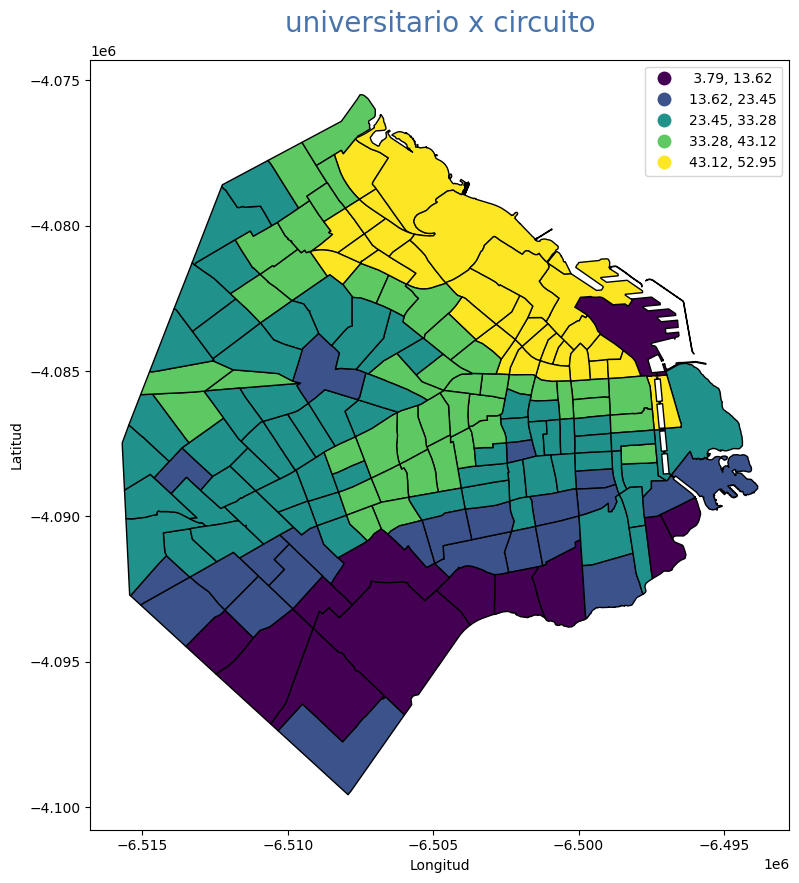

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('universitario x circuito', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
universitario_x_circuito.plot(column='%univ sobre totpers x circuito',edgecolor="black",scheme='equalinterval', k = 5, legend=True, ax=ax, zorder=5)

<AxesSubplot: title={'center': 'universitario x comuna'}, xlabel='Longitud', ylabel='Latitud'>

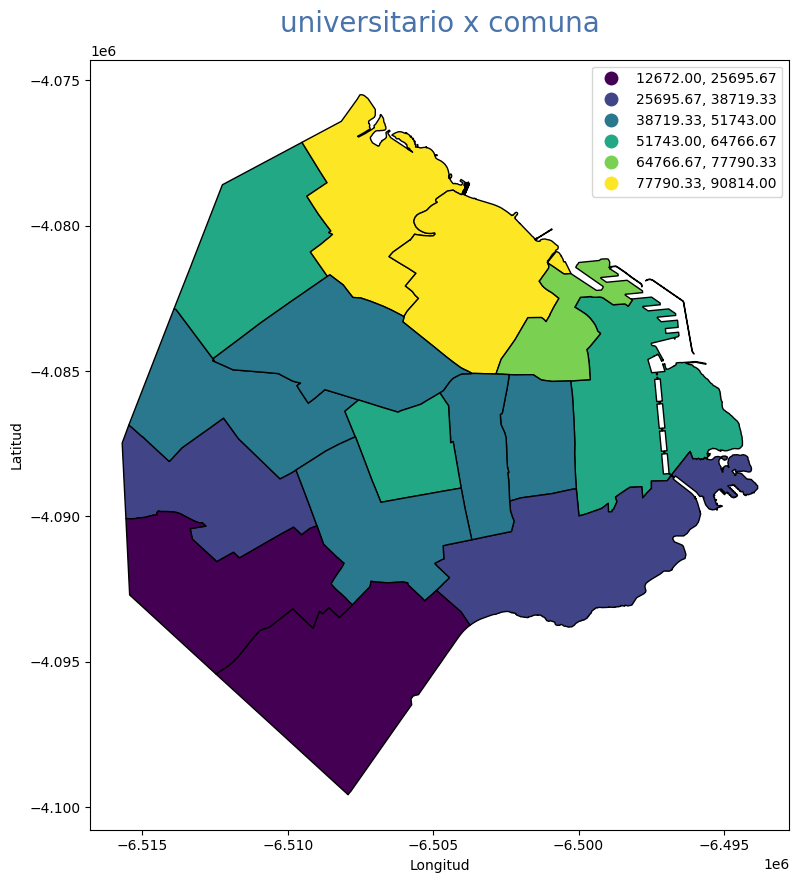

In [67]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('universitario x comuna', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
universitario_x_comuna = universitario_x_circuito[['departamen','P09','geometry']].dissolve(by='departamen', aggfunc='sum')
universitario_x_comuna.plot(column= "P09",scheme='equalinterval',edgecolor="black", k = 6, legend=True,ax=ax, zorder=5)

PUNTO 2

el data frame que nos decia el porcentaje de  nuestro candidato por circuito ya la teniamos

In [68]:
porcentaje_votos_x_comunas

COMUNA  circuito        pp1        pp2        pp3        pp4         nv  \
0         1         1  24.011299  25.951855  15.192827  14.517318  20.326701   
1         1         2  23.997606  25.397965  14.602035  16.636744  19.365649   
2         1         3  23.166023  31.351351  11.042471  14.787645  19.652510   
3         1         4  26.188620  28.916602  10.911925  15.276695  18.706157   
4         1         5  23.126961  23.229672  17.283880  16.713267  19.646220   
..      ...       ...        ...        ...        ...        ...        ...   
162      15       163  20.905605  20.777798  18.623334  19.846631  19.846631   
163      15       164  20.421094  18.520324  19.875232  20.528317  20.655035   
164      15       165  20.958119  20.784336  18.287667  19.689509  20.280368   
165      15       166  21.232485  18.365742  19.824135  20.574778  20.002860   
166      15       167  21.341298  18.399855  18.924790  20.970224  20.363834   

     total  
0    100.0  
1    100.0  
2    100.0  
3    100.0  
4    100.0  
..     ...  
162  100.0  
163  100.0  
164  100.0  
165  100.0  
166  100.0  

[167 rows x 8 columns]

In [69]:
universitario_cruzado= pd.merge(universitario_x_circuito,porcentaje_votos_x_comunas, on="circuito", how="inner")
universitario_cruzado=universitario_cruzado[["geometry","COMUNA","circuito","pp1", "pp2", "pp3", "pp4", "nv", "total" , "TOTPERS", "P09", "%univ sobre totpers x circuito" ]]
universitario_cruzado

geometry  COMUNA  circuito  \
0    POLYGON Z ((-6497294.216 -4088142.493 0.000, -...       1         1   
1    POLYGON Z ((-6498537.655 -4087740.684 0.000, -...       1         2   
2    POLYGON Z ((-6496304.252 -4084732.697 0.000, -...       1         3   
3    POLYGON Z ((-6497398.411 -4087025.705 0.000, -...       1         4   
4    MULTIPOLYGON Z (((-6497185.903 -4082052.692 0....       1         5   
..                                                 ...     ...       ...   
162  POLYGON Z ((-6505348.070 -4083866.211 0.000, -...      15       163   
163  POLYGON Z ((-6507652.050 -4084945.661 0.000, -...      15       164   
164  POLYGON Z ((-6508638.340 -4081745.040 0.000, -...      15       165   
165  POLYGON Z ((-6508941.686 -4083702.129 0.000, -...      15       166   
166  POLYGON Z ((-6509514.870 -4084304.493 0.000, -...      15       167   

           pp1        pp2        pp3        pp4         nv  total  TOTPERS  \
0    24.011299  25.951855  15.192827  14.517318  20.326701  100.0     8661   
1    23.997606  25.397965  14.602035  16.636744  19.365649  100.0     8506   
2    23.166023  31.351351  11.042471  14.787645  19.652510  100.0     2639   
3    26.188620  28.916602  10.911925  15.276695  18.706157  100.0     1290   
4    23.126961  23.229672  17.283880  16.713267  19.646220  100.0    18958   
..         ...        ...        ...        ...        ...    ...      ...   
162  20.905605  20.777798  18.623334  19.846631  19.846631  100.0    11217   
163  20.421094  18.520324  19.875232  20.528317  20.655035  100.0    10935   
164  20.958119  20.784336  18.287667  19.689509  20.280368  100.0    17482   
165  21.232485  18.365742  19.824135  20.574778  20.002860  100.0    14230   
166  21.341298  18.399855  18.924790  20.970224  20.363834  100.0    11221   

      P09  %univ sobre totpers x circuito  
0    2755                       31.809260  
1    2882                       33.881966  
2     802                       30.390299  
3     674                       52.248062  
4    1641                        8.655976  
..    ...                             ...  
162  3188                       28.421146  
163  3114                       28.477366  
164  5633                       32.221714  
165  4022                       28.264230  
166  3564                       31.761875  

[167 rows x 12 columns]

In [78]:
universitario_pp3 = universitario_cruzado[["pp3","%univ sobre totpers x circuito"]]
universitario_pp1 = universitario_cruzado[["pp1","%univ sobre totpers x circuito"]]
universitario_pp2 = universitario_cruzado[["pp2","%univ sobre totpers x circuito"]]
universitario_pp4 = universitario_cruzado[["pp4","%univ sobre totpers x circuito"]]
universitario_votos = universitario_cruzado[["pp1","pp2", "pp3", "pp4","nv","%univ sobre totpers x circuito"]]

In [ ]:
universitario_pp3.corr()

pp3  %univ sobre totpers x circuito
pp3                             1.000000                        0.439985
%univ sobre totpers x circuito  0.439985                        1.000000

In [ ]:
universitario_pp2.corr()

pp2  %univ sobre totpers x circuito
pp2                             1.000000                       -0.286477
%univ sobre totpers x circuito -0.286477                        1.000000

In [79]:
universitario_votos.corr()

pp1       pp2       pp3       pp4  \
pp1                             1.000000  0.420262 -0.670075 -0.606284   
pp2                             0.420262  1.000000 -0.931432 -0.939891   
pp3                            -0.670075 -0.931432  1.000000  0.901810   
pp4                            -0.606284 -0.939891  0.901810  1.000000   
nv                             -0.101232 -0.041006  0.043217 -0.005858   
%univ sobre totpers x circuito -0.705234 -0.286477  0.439985  0.458343   

                                      nv  %univ sobre totpers x circuito  
pp1                            -0.101232                       -0.705234  
pp2                            -0.041006                       -0.286477  
pp3                             0.043217                        0.439985  
pp4                            -0.005858                        0.458343  
nv                              1.000000                       -0.014679  
%univ sobre totpers x circuito -0.014679                        1.000000

PUNTO 4

In [73]:
jovenes_x_circuito= pd.merge(jovenes, tabla_intermedia, on="RADIO", how="inner")
jovenes_x_circuito= jovenes_x_circuito[["circuito","P03","TOTPERS"]].groupby(["circuito"]).sum()
jovenes_x_circuito.reset_index(inplace=True)
jovenes_x_circuito

circuito   P03  TOTPERS
0           1  1865     8661
1           2  2182     8506
2           3   780     2639
3           4   250     1290
4           5  8356    18958
..        ...   ...      ...
162       163  2594    11217
163       164  2700    10935
164       165  3847    17482
165       166  2831    14230
166       167  2266    11221

[167 rows x 3 columns]

In [ ]:
tabla_aux2= universitario_cruzado[["geometry","COMUNA","circuito","pp1", "pp2", "pp3", "pp4", "nv"]]
jovenes_x_circuito=pd.merge(tabla_aux2,jovenes_x_circuito, how="left", on="circuito",)
jovenes_x_circuito

geometry  COMUNA  circuito  \
0    POLYGON Z ((-6497294.216 -4088142.493 0.000, -...       1         1   
1    POLYGON Z ((-6498537.655 -4087740.684 0.000, -...       1         2   
2    POLYGON Z ((-6496304.252 -4084732.697 0.000, -...       1         3   
3    POLYGON Z ((-6497398.411 -4087025.705 0.000, -...       1         4   
4    MULTIPOLYGON Z (((-6497185.903 -4082052.692 0....       1         5   
..                                                 ...     ...       ...   
162  POLYGON Z ((-6505348.070 -4083866.211 0.000, -...      15       163   
163  POLYGON Z ((-6507652.050 -4084945.661 0.000, -...      15       164   
164  POLYGON Z ((-6508638.340 -4081745.040 0.000, -...      15       165   
165  POLYGON Z ((-6508941.686 -4083702.129 0.000, -...      15       166   
166  POLYGON Z ((-6509514.870 -4084304.493 0.000, -...      15       167   

           pp1        pp2        pp3        pp4         nv   P03  TOTPERS  
0    24.011299  25.951855  15.192827  14.517318  20.326701  1865     8661  
1    23.997606  25.397965  14.602035  16.636744  19.365649  2182     8506  
2    23.166023  31.351351  11.042471  14.787645  19.652510   780     2639  
3    26.188620  28.916602  10.911925  15.276695  18.706157   250     1290  
4    23.126961  23.229672  17.283880  16.713267  19.646220  8356    18958  
..         ...        ...        ...        ...        ...   ...      ...  
162  20.905605  20.777798  18.623334  19.846631  19.846631  2594    11217  
163  20.421094  18.520324  19.875232  20.528317  20.655035  2700    10935  
164  20.958119  20.784336  18.287667  19.689509  20.280368  3847    17482  
165  21.232485  18.365742  19.824135  20.574778  20.002860  2831    14230  
166  21.341298  18.399855  18.924790  20.970224  20.363834  2266    11221  

[167 rows x 10 columns]

In [ ]:
jovenes_x_circuito["%jov sobre totpers x circuito"] = jovenes_x_circuito.apply(
    (lambda x: (x["P03"] + 0.0) / x["TOTPERS"] * 100), axis=1
)

In [ ]:
jovenes_cruzado=jovenes_x_circuito

In [ ]:
jovenes_pp3 = jovenes_cruzado[["pp3","%jov sobre totpers x circuito"]]
jovenes_pp1 = jovenes_cruzado[["pp1","%jov sobre totpers x circuito"]]
jovenes_pp2 = jovenes_cruzado[["pp2","%jov sobre totpers x circuito"]]
jovenes_pp4 = jovenes_cruzado[["pp4","%jov sobre totpers x circuito"]]
chachan= jovenes_cruzado[["pp3","pp1","pp2","pp4","%jov sobre totpers x circuito"]]

In [ ]:
jovenes_pp3.corr()

pp3  %jov sobre totpers x circuito
pp3                            1.00000                       -0.18212
%jov sobre totpers x circuito -0.18212                        1.00000

In [ ]:
jovenes_pp2.corr()

pp2  %jov sobre totpers x circuito
pp2                            1.000000                       0.186879
%jov sobre totpers x circuito  0.186879                       1.000000

In [ ]:
aca cree un cuadro que cruza todo. hayq ue ver solo la ultima columna

In [ ]:
chachan.corr()

pp3       pp1       pp2       pp4  \
pp3                            1.000000 -0.670075 -0.931432  0.901810   
pp1                           -0.670075  1.000000  0.420262 -0.606284   
pp2                           -0.931432  0.420262  1.000000 -0.939891   
pp4                            0.901810 -0.606284 -0.939891  1.000000   
%jov sobre totpers x circuito -0.182120  0.090117  0.186879 -0.168977   

                               %jov sobre totpers x circuito  
pp3                                                -0.182120  
pp1                                                 0.090117  
pp2                                                 0.186879  
pp4                                                -0.168977  
%jov sobre totpers x circuito                       1.000000

<AxesSubplot:title={'center':'jovenes x circuito'}, xlabel='Longitud', ylabel='Latitud'>

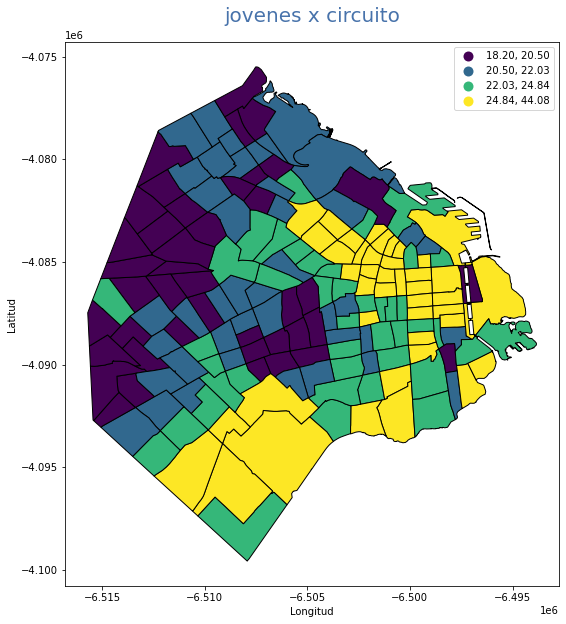

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('jovenes x circuito', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
jovenes_x_circuito.plot(column= "%jov sobre totpers x circuito",scheme='quantiles',edgecolor="black", k = 4, legend=True,ax=ax, zorder=5)


<AxesSubplot:title={'center':'jovenes x comuna'}, xlabel='Longitud', ylabel='Latitud'>

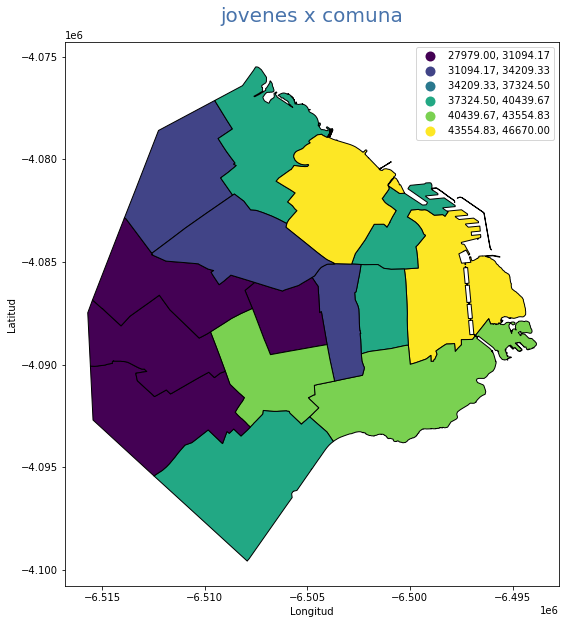

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('jovenes x comuna', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
jovenes_x_comuna = jovenes_x_circuito[['COMUNA','P03','geometry']].dissolve(by='COMUNA', aggfunc='sum')
jovenes_x_comuna.plot(column= "P03",scheme='equalinterval',edgecolor="black", k = 6, legend=True,ax=ax, zorder=5)

vamos a estudiar un poco donde le fue mejor a nuesro candidato.
primero vamos a ver una lista de los 20 circuitos en que nos fue mejor

In [80]:
top20=porcentaje_orden.head(20)
top20

COMUNA  circuito        pp1        pp2        pp3        pp4         nv  \
20        2        21  14.911404   9.859155  32.975920  21.899137  20.354384   
143      13       144  13.819275   9.752255  32.120865  23.857941  20.449663   
19        2        20  14.582606  14.093608  30.387705  20.817324  20.118757   
137      13       138  13.913556  10.998035  30.133595  24.632613  20.322200   
154      14       155  13.342616  12.137507  29.791627  25.000000  19.728250   
9         1        10  14.911260  13.791097  28.135001  22.665115  20.497527   
142      13       143  15.824808  12.078005  28.101023  23.714834  20.281330   
8         1         9  16.738583  15.498022  27.454153  21.125494  19.183747   
115      11       116  16.700166  11.811303  27.240482  24.178293  20.069756   
26        2        27  14.518594  14.645950  26.889115  24.172185  19.774155   
148      14       149  14.228281  13.895564  26.834566  24.972274  20.069316   
114      11       115  17.461099  12.044514  26.738231  23.695096  20.061060   
141      13       142  15.743011  13.462482  26.454144  24.242276  20.098087   
147      14       148  14.971394  13.877778  25.998684  24.996203  20.155941   
24        2        25  15.247630  15.575441  25.471782  23.815008  19.890139   
153      14       154  15.611730  15.779986  25.382582  23.299415  19.926288   
102      10       103  18.239926  12.765169  25.196850  23.677629  20.120426   
113      11       114  18.822264  12.960473  24.704222  23.964775  19.548266   
69        6        70  18.834061  14.283843  24.633188  21.991266  20.257642   
112      11       113  19.285209  12.455768  24.601911  23.522647  20.134466   

     total  
20   100.0  
143  100.0  
19   100.0  
137  100.0  
154  100.0  
9    100.0  
142  100.0  
8    100.0  
115  100.0  
26   100.0  
148  100.0  
114  100.0  
141  100.0  
147  100.0  
24   100.0  
153  100.0  
102  100.0  
113  100.0  
69   100.0  
112  100.0

In [81]:
top20univ= pd.merge(universitario_x_circuito,top20, on="circuito", how="right")
top20univ


distrito                        provincia departamen   cabecera  circuito  \
0        01  Ciudad Autónoma de Buenos Aires   Comuna 2   Comuna 2        21   
1        01  Ciudad Autónoma de Buenos Aires  Comuna 13  Comuna 13       144   
2        01  Ciudad Autónoma de Buenos Aires   Comuna 2   Comuna 2        20   
3        01  Ciudad Autónoma de Buenos Aires  Comuna 13  Comuna 13       138   
4        01  Ciudad Autónoma de Buenos Aires  Comuna 14  Comuna 14       155   
5        01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1        10   
6        01  Ciudad Autónoma de Buenos Aires  Comuna 13  Comuna 13       143   
7        01  Ciudad Autónoma de Buenos Aires   Comuna 1   Comuna 1         9   
8        01  Ciudad Autónoma de Buenos Aires  Comuna 11  Comuna 11       116   
9        01  Ciudad Autónoma de Buenos Aires   Comuna 2   Comuna 2        27   
10       01  Ciudad Autónoma de Buenos Aires  Comuna 14  Comuna 14       149   
11       01  Ciudad Autónoma de Buenos Aires  Comuna 11  Comuna 11       115   
12       01  Ciudad Autónoma de Buenos Aires  Comuna 13  Comuna 13       142   
13       01  Ciudad Autónoma de Buenos Aires  Comuna 14  Comuna 14       148   
14       01  Ciudad Autónoma de Buenos Aires   Comuna 2   Comuna 2        25   
15       01  Ciudad Autónoma de Buenos Aires  Comuna 14  Comuna 14       154   
16       01  Ciudad Autónoma de Buenos Aires  Comuna 10  Comuna 10       103   
17       01  Ciudad Autónoma de Buenos Aires  Comuna 11  Comuna 11       114   
18       01  Ciudad Autónoma de Buenos Aires   Comuna 6   Comuna 6        70   
19       01  Ciudad Autónoma de Buenos Aires  Comuna 11  Comuna 11       113   

   indec_p indec_d                                           geometry    P09  \
0       02     002  POLYGON Z ((-6499480.531 -4083338.976 0.000, -...   5736   
1       02     013  POLYGON Z ((-6507487.742 -4081295.016 0.000, -...   3343   
2       02     002  POLYGON Z ((-6498900.223 -4081409.539 0.000, -...   2718   
3       02     013  POLYGON Z ((-6508281.895 -4080935.980 0.000, -...  11304   
4       02     014  POLYGON Z ((-6505315.565 -4083891.651 0.000, -...   8791   
5       02     001  POLYGON Z ((-6499595.747 -4085296.212 0.000, -...   3037   
6       02     013  POLYGON Z ((-6506882.721 -4080829.670 0.000, -...   7336   
7       02     001  POLYGON Z ((-6498971.912 -4085261.748 0.000, -...   3524   
8       02     011  POLYGON Z ((-6509296.684 -4086105.994 0.000, -...   4563   
9       02     002  POLYGON Z ((-6500923.566 -4085357.600 0.000, -...   6329   
10      02     014  POLYGON Z ((-6503253.371 -4080723.227 0.000, -...  10724   
11      02     011  POLYGON Z ((-6509031.410 -4087970.403 0.000, -...   2536   
12      02     013  POLYGON Z ((-6505642.176 -4080297.735 0.000, -...  10398   
13      02     014  POLYGON Z ((-6504554.251 -4081981.094 0.000, -...  10063   
14      02     002  POLYGON Z ((-6500893.398 -4084766.889 0.000, -...   5944   
15      02     014  POLYGON Z ((-6504474.991 -4083019.309 0.000, -...  11948   
16      02     010  POLYGON Z ((-6514076.965 -4088113.542 0.000, -...   2843   
17      02     011  POLYGON Z ((-6510008.127 -4086484.856 0.000, -...   4155   
18      02     006  POLYGON Z ((-6506205.564 -4086416.595 0.000, -...   8926   
19      02     011  POLYGON Z ((-6509739.735 -4088418.408 0.000, -...   2978   

    TOTPERS  %univ sobre totpers x circuito  COMUNA        pp1        pp2  \
0     11782                       48.684434       2  14.911404   9.859155   
1      7266                       46.008808      13  13.819275   9.752255   
2      5832                       46.604938       2  14.582606  14.093608   
3     25830                       43.763066      13  13.913556  10.998035   
4     21263                       41.344119      14  13.342616  12.137507   
5      7137                       42.552893       1  14.911260  13.791097   
6     15778                       46.495120      13  15.824808  12.078005   
7      8224              

<AxesSubplot:title={'center':'20 circuitos d emayor rendimiento'}, xlabel='Longitud', ylabel='Latitud'>

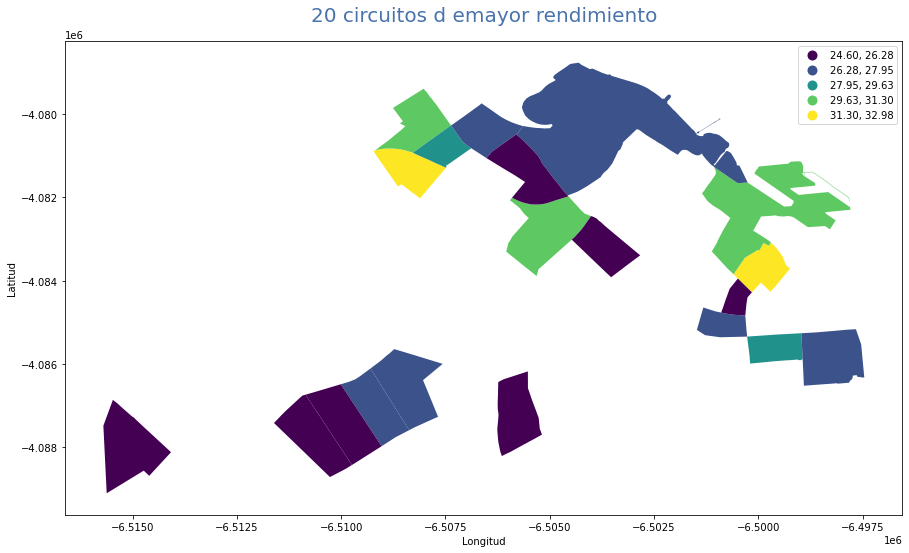

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
 
# Control del título y los ejes
ax.set_title('20 circuitos d emayor rendimiento', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
 
# Mostrar el mapa finalizado
top20univ.plot(column='pp3', cmap='viridis',scheme='equalinterval', k = 5, legend=True, ax=ax, zorder=5)

In [ ]:
top20univ= top20univ[["%univ sobre totpers x circuito","pp3"]]
top20univ.corr()

%univ sobre totpers x circuito       pp3
%univ sobre totpers x circuito                        1.000000  0.378254
pp3                                                   0.378254  1.000000